In [2]:
from rivapy.models.gbm import GBM
from rivapy.models.heston_for_DH import HestonForDeepHedging
from rivapy.models.heston_with_jumps import HestonWithJumps
from rivapy.models.barndorff_nielsen_shephard import BNS

import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import numpy as np
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import plotly.express as px
import plotly
plotly.offline.init_notebook_mode()
import plotly.graph_objects as go

from rivapy.tools.datetime_grid import DateTimeGrid

from rivapy.instruments.specifications import EuropeanVanillaSpecification
from rivapy.pricing.vanillaoption_pricing import VanillaOptionDeepHedgingPricer, DeepHedgeModelwEmbedding

import analysis

%load_ext autoreload
%autoreload 2
%matplotlib inline

C:\Users\Anwender\Documents\GitHub\RiVaPy_development\RiVaPy\rivapy\__init__.py:11: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')


In [3]:
from rivapy.models.gbm import GBM
from rivapy.models.heston_for_DH import HestonForDeepHedging
#from rivapy.models.roughbergomi_for_DH import rBergomiForDeepHedging
from rivapy.models.heston_with_jumps import HestonWithJumps
from rivapy.models.barndorff_nielsen_shephard import BNS

#import sys
#sys.path.insert(0,'../..')
import numpy as np
import matplotlib.pyplot as plt

import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# GBM

(array([0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8]),
 [Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2'),
  Text(0, 1.4000000000000001, '1.4'),
  Text(0, 1.6, '1.6'),
  Text(0, 1.8000000000000003, '1.8')])

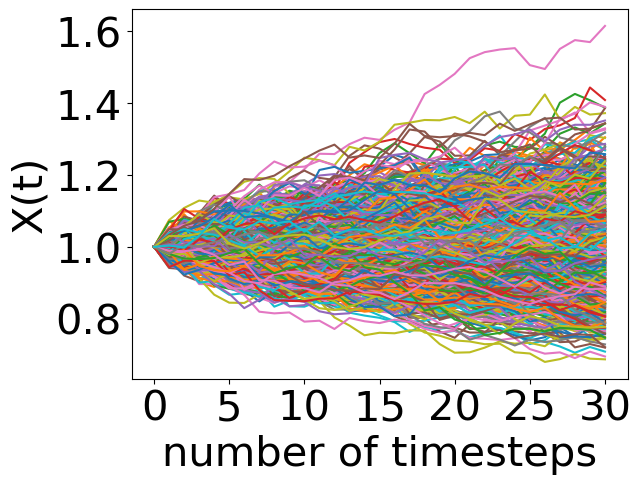

In [66]:
np.random.seed(123)
n = 30
T = n/365
ttm = T
timegrid = np.linspace(0.0,T,n) # simulate on daily timegrid over 30 days
n_sims = 1000
S0 = 1.#24.6144
K = S0

model_GBM = GBM(0,0.4)
paths_GBM = model_GBM.simulate(timegrid, S0=S0, v0=0., M=n_sims,n=n,model_name='GBM')
#price = model_GBM.compute_call_price(S0=S0,K=K,ttm=ttm)
#print(price)

plt.figure()
plt.plot(paths_GBM)#,color='blue')

plt.xlabel('number of timesteps',size=30)
plt.ylabel('X(t)',size=30)
#plt.title('',size=30)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)


In [3]:
repo = analysis.Repo('./test_ins')
key_list = list(repo.results.keys())

In [4]:
experiments = {}
key_list = []
for k,v in repo.results.items():  
        key_list.append(k)

In [5]:
def get_sim_results_and_paths(ref_keys,model,emb,n_sims):
    sim_results = {}
    paths = {}
    sim_results[ref_keys], emb_vec = repo.simulate_model(ref_keys, n_sims=n_sims, days = 30, freq='D',model=model,emb=emb)
    paths = {ref_keys:{'ADS':sim_results[ref_keys]}}
    additional_states_ = {}
    additional_states_["emb_key"] = emb_vec
    paths[ref_keys].update(additional_states_) 

    return sim_results, paths
    

def get_hedge_model_and_embedding(ref_keys):
    get_hedge_model = repo.get_hedge_model(ref_keys)
    hedge_model = {ref_keys: get_hedge_model[0]}
    embedding = {ref_keys: get_hedge_model[1]}

    return hedge_model, embedding

def get_specs(ref_keys):
    specs = {ref_keys: EuropeanVanillaSpecification.from_dict(repo.results[ref_keys]['spec'][0])}

    return specs

def compute_pnl(n_sims, specs, paths, hedge_model):
    payoff = np.zeros((n_sims,))
    v = paths['ADS']
    payoff -= np.maximum(v[-1,:] - specs.strike,0)
    pnl = hedge_model.compute_pnl(paths, payoff)
    return pnl

def compute_pnl_and_loss(n_sims, specs, paths, hedge_model):
    payoff = np.zeros((n_sims,))
    v = paths['ADS']
    payoff -= np.maximum(v[-1,:] - specs.strike,0)
    pnl = hedge_model.compute_pnl(paths, payoff)
    inputs = hedge_model._create_inputs(paths)
    loss = hedge_model.evaluate(inputs, payoff)
    return pnl, loss

def get_pnl(hedge_model, specs, paths, n_sims):
    pnl = {}
    for k,v in hedge_model.items():
        pnl[k] = compute_pnl(n_sims, specs[k], paths[k], hedge_model[k])

    return pnl

def get_pnl_and_loss(hedge_model, specs, paths, n_sims):
    pnl = {}
    loss = {}
    for k,v in hedge_model.items():
        p, l = compute_pnl_and_loss(n_sims, specs[k], paths[k], hedge_model[k])
        pnl[k] = p
        loss[k] = l

    return pnl, loss

def compute_delta(paths, t, hedge_model,emb):
    delta = hedge_model.compute_delta(paths,t,emb).reshape((-1,))
    return delta 

def get_delta(hedge_model, t, paths,emb):
    delta = {}
    for k,v in hedge_model.items():
        delta[k] = compute_delta(paths[k], t, hedge_model[k],emb)

    return delta

def get_price(ref_keys,model,n_sims,sim_results):
    price = repo.get_call_price(ref_keys, sim_results=sim_results[ref_keys], seed=42, model=model,n_sims=n_sims,days=30,freq='D')
    return price



In [43]:
for i in range(len(key_list)):
    print(i, repo.results[key_list[i]]['pricing_param']['n_sims'])

0 64000


In [44]:
index = 0

tmp={
        'ref_keys':key_list[index],#key_list[0]
        'labels':{ key_list[index]: 'GBMonly'                
        }
}
experiments['GBMonly'] = tmp

experiment = 'GBMonly'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
#labels_T = {k:v for v,k in labels.items()}
#loop = 4
#model_list = []
#for i in range(loop):
#    model_list.append(HestonForDeepHedging(rate_of_mean_reversion = model_params['Heston']['rate_of_mean_reversion'][i],
#                                      long_run_average = model_params['Heston']['long_run_average'][i],
#                                      vol_of_vol = model_params['Heston']['vol_of_vol'][i], 
#                                      correlation_rho = model_params['Heston']['correlation_rho'][i],
#                                      v0 = model_params['Heston']['v0'][i]))
model_list = [GBM(drift=0.0, volatility=0.2)]#, GBM(drift=0.0, volatility=0.2),GBM(drift=0.0, volatility=0.3),GBM(drift=0.0, volatility=0.4)]
sim_results_list = []
paths_list = []
pnl_list = []
delta_list = []
hedge_model_list = []


count = 0
n_sims = 64000
t = 28
print('get hedge model and embedding')
hedge_model, embedding = get_hedge_model_and_embedding(ref_keys)
print('get specs')
specs = get_specs(ref_keys)
print('get sim_results, paths, pnl and delta for model:')
for i in model_list:
    hedge_model_list.append(hedge_model)
    sim_results, paths = get_sim_results_and_paths(ref_keys,i,count,n_sims)
    sim_results_list.append(sim_results)
    paths_list.append(paths)
    pnl = get_pnl(hedge_model, specs, paths_list[count], n_sims)
    delta = get_delta(hedge_model_list[count], t, paths_list[count],count)
    pnl_list.append(pnl)
    delta_list.append(delta)
    count = count + 1


get hedge model and embedding
get specs
get sim_results, paths, pnl and delta for model:
2000/2000 [==============================] - 6s 3ms/step


In [45]:
timegrid = VanillaOptionDeepHedgingPricer._compute_timegrid(days=30,freq='D')
delta_BS_02 = model_list[0].compute_BS_delta(paths_list[0][key_list[index]]['ADS'][t,:],timegrid)


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

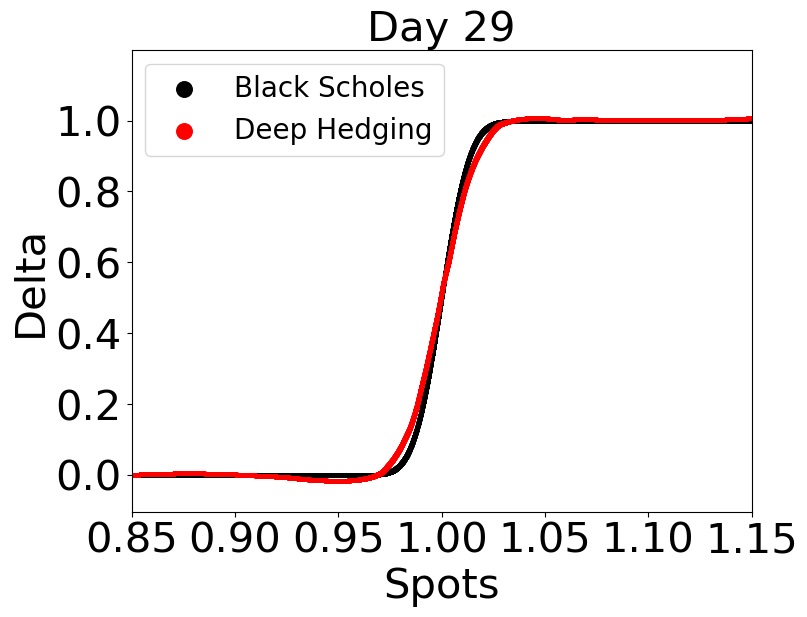

In [67]:
colors = ['red']
vol = [0.2]
plt.figure(figsize=[8,6])
plt.scatter(x = paths_list[0][key_list[index]]['ADS'][t,:], y = delta_BS_02, label ='Black Scholes', color = 'black',s =5)
for i in range(len(colors)):
    paths = paths_list[i][key_list[index]]['ADS'][t,:]
    df_delta = delta_list[i][key_list[index]]
    plt.scatter(x = paths_list[i][key_list[index]]['ADS'][t,:], y =delta_list[i][key_list[index]], s = 5,label='Deep Hedging', alpha=1.,color=colors[i])
plt.xlim([0.85,1.15])
plt.legend(markerscale=5,fontsize=20,loc='upper left')
plt.xlabel('Spots',size=30)
plt.ylabel('Delta',size=30)
plt.title('Day 29',size=30)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)



In [118]:
repo = analysis.Repo('./multitask_GBM_vanillacalloption/')
key_list = list(repo.results.keys())

In [119]:
experiments = {}
key_list = []
for k,v in repo.results.items():  
        key_list.append(k)

In [84]:
def get_sim_results_and_paths(ref_keys,model,emb,n_sims):
    sim_results = {}
    paths = {}
    sim_results[ref_keys], emb_vec = repo.simulate_model(ref_keys, n_sims=n_sims, days = 30, freq='D',model=model,emb=emb)
    paths = {ref_keys:{'ADS':sim_results[ref_keys]}}
    additional_states_ = {}
    additional_states_["emb_key"] = emb_vec
    paths[ref_keys].update(additional_states_) 

    return sim_results, paths
    
def get_hedge_model_and_embedding(ref_keys):
    get_hedge_model = repo.get_hedge_model(ref_keys)
    hedge_model = {ref_keys: get_hedge_model[0]}
    embedding = {ref_keys: get_hedge_model[1]}

    return hedge_model, embedding

def get_specs(ref_keys):
    specs = {ref_keys: EuropeanVanillaSpecification.from_dict(repo.results[ref_keys]['spec'][0])}

    return specs

def compute_pnl(n_sims, specs, paths, hedge_model):
    payoff = np.zeros((n_sims,))
    v = paths['ADS']
    payoff -= np.maximum(v[-1,:] - specs.strike,0)
    pnl = hedge_model.compute_pnl(paths, payoff)
    return pnl

def get_pnl(hedge_model, specs, paths, n_sims):
    pnl = {}
    for k,v in hedge_model.items():
        pnl[k] = compute_pnl(n_sims, specs[k], paths[k], hedge_model[k])

    return pnl

def compute_delta(paths, t, hedge_model,emb):
    delta = hedge_model.compute_delta(paths,t,emb).reshape((-1,))
    return delta 

def get_delta(hedge_model, t, paths,emb):
    delta = {}
    for k,v in hedge_model.items():
        delta[k] = compute_delta(paths[k], t, hedge_model[k],emb)

    return delta

def get_price(ref_keys,model,n_sims,sim_results):
    price = repo.get_call_price(ref_keys, sim_results=sim_results[ref_keys], seed=42, model=model,n_sims=n_sims,days=30,freq='D')
    return price

In [6]:
index = 0

In [7]:
repo.results[key_list[index]]

{'val_date': '2023-01-01T00:00:00',
 'spec': [{'id': 'Test_Call1',
   'issuer': 'DBK',
   'sec_lvl': 'COLLATERALIZED',
   'curr': 'EUR',
   'udl_id': 'ADS',
   'type': 'CALL',
   'expiry': '2023-01-31T00:00:00',
   'strike': 1.0,
   'share_ratio': 1,
   'long_short_flag': 'long',
   'cls': 'EuropeanVanillaSpecification'}],
 'model': [{'drift': 0.0, 'volatility': 0.1, 'cls': 'GBM'},
  {'drift': 0.0, 'volatility': 0.2, 'cls': 'GBM'},
  {'drift': 0.0, 'volatility': 0.3, 'cls': 'GBM'},
  {'drift': 0.0, 'volatility': 0.4, 'cls': 'GBM'}],
 'pricing_param': {'depth': 3,
  'nb_neurons': 64,
  'n_sims': 256000,
  'regularization': 0.0,
  'epochs': 1000,
  'verbose': 1,
  'tensorboard_logdir': 'logs/20240624T080839',
  'initial_lr': 0.005,
  'decay_steps': 16000,
  'batch_size': 256,
  'decay_rate': 0.95,
  'seed': 0,
  'days': 30,
  'embedding_size': 1},
 'spec_hash': {'Test_Call1': 'c256412e687a022f6453d9a3f2095801befda8f4'},
 'model_hash': {'GBM': '81e7371b612510358156ca6c8f62cda06e201285'},


In [8]:
tmp={
        'ref_keys':key_list[index],#key_list[0]
        'labels':{ key_list[index]: 'GBMonly'                
        }
}
experiments['GBMonly'] = tmp

experiment = 'GBMonly'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
#labels_T = {k:v for v,k in labels.items()}
#loop = 4
#model_list = []
#for i in range(loop):
#    model_list.append(HestonForDeepHedging(rate_of_mean_reversion = model_params['Heston']['rate_of_mean_reversion'][i],
#                                      long_run_average = model_params['Heston']['long_run_average'][i],
#                                      vol_of_vol = model_params['Heston']['vol_of_vol'][i], 
#                                      correlation_rho = model_params['Heston']['correlation_rho'][i],
#                                      v0 = model_params['Heston']['v0'][i]))
model_list = [GBM(drift=0.0, volatility=0.1), GBM(drift=0.0, volatility=0.2),GBM(drift=0.0, volatility=0.3),GBM(drift=0.0, volatility=0.4)]
sim_results_list = []
paths_list = []
pnl_list = []
delta_list = []
hedge_model_list = []


count = 0
n_sims = 64000
t = 28
print('get hedge model and embedding')
hedge_model, embedding = get_hedge_model_and_embedding(ref_keys)
print('get specs')
specs = get_specs(ref_keys)
print('get sim_results, paths, pnl and delta for model:')
for i in model_list:
    hedge_model_list.append(hedge_model)
    sim_results, paths = get_sim_results_and_paths(ref_keys,i,count,n_sims)
    sim_results_list.append(sim_results)
    paths_list.append(paths)
    pnl = get_pnl(hedge_model, specs, paths_list[count], n_sims)
    delta = get_delta(hedge_model_list[count], t, paths_list[count],count)
    pnl_list.append(pnl)
    delta_list.append(delta)
    count = count + 1


get hedge model and embedding
get specs
get sim_results, paths, pnl and delta for model:
2000/2000 [==============================] - 2s 1ms/step


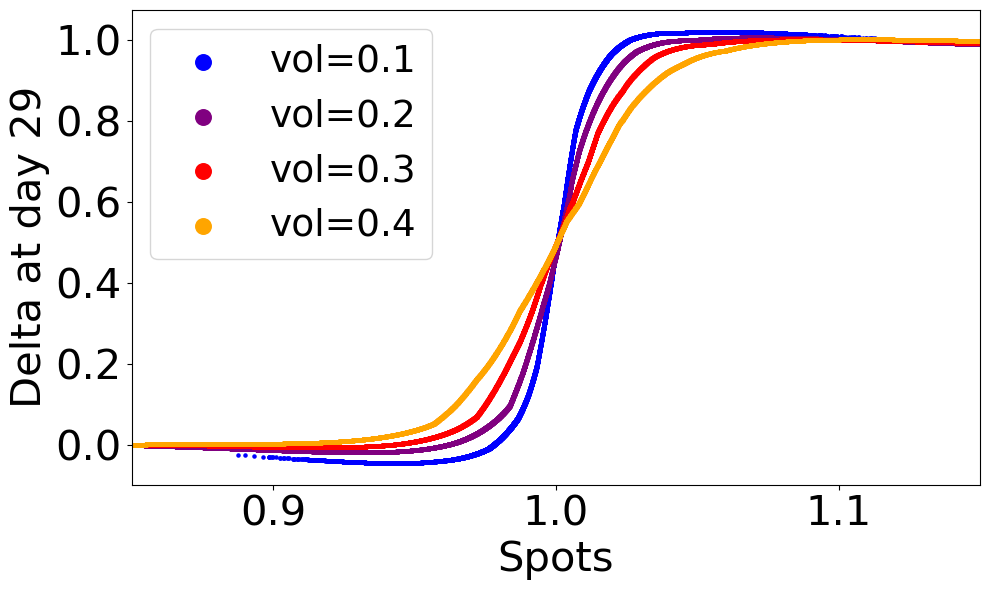

In [132]:
colors = ['blue','purple','red','orange']
vol = [0.1,0.2,0.3,0.4]
plt.figure(figsize=[10,6])
for i in range(len(colors)):
    paths = paths_list[i][key_list[index]]['ADS'][t,:]
    df_delta = delta_list[i][key_list[index]]
    plt.scatter(x = paths_list[i][key_list[index]]['ADS'][t,:], y =delta_list[i][key_list[index]], s = 5,label='vol='+str(vol[i]), alpha=1.,color=colors[i])
#plt.scatter(x = paths_list[2][key_list[index]]['ADS'][t,:], y = delta_BS_03, label ='Black Scholes vol=0.3', color = 'black',s =1)
plt.xlim([0.85,1.15])
plt.legend(markerscale=5,fontsize=27,loc='upper left')
plt.xlabel('Spots',size=30)
plt.ylabel('Delta at day 29',size=30)
plt.xticks([0.9,1.,1.1],fontsize = 30)
plt.yticks(fontsize = 30)
plt.tight_layout()


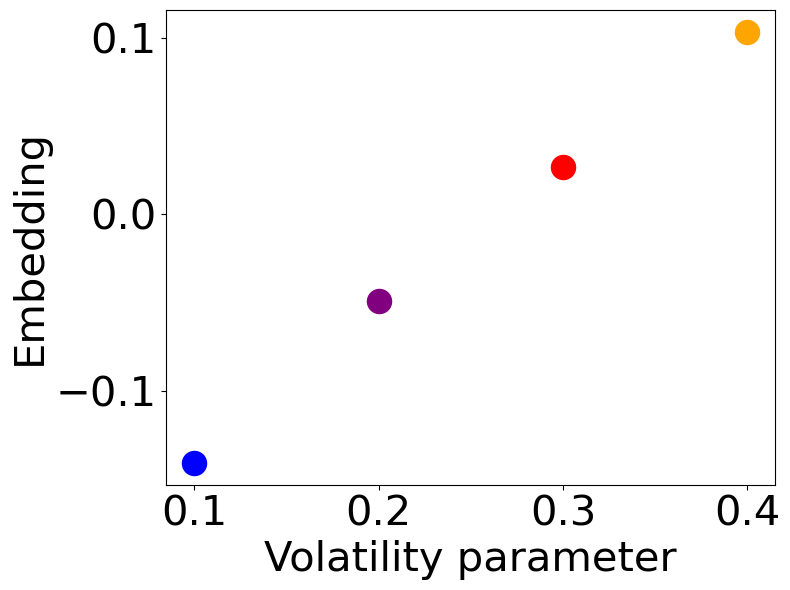

In [99]:
(w,) = embedding[key_list[index]]
vol = [0.1,0.2,0.3,0.4,0.5]
colors = ['blue','purple','red','orange']
plt.figure(figsize=[8,6])
for i in range(len(colors)):
    plt.scatter(vol[i],w[i],s=300.,c=colors[i])
plt.xlabel('Volatility parameter',size=30)
plt.ylabel('Embedding',size=30)
plt.xticks([0.1,0.2,0.3,0.4],fontsize = 30)
plt.yticks([-0.1,0.,0.1],fontsize = 30)
plt.tight_layout()

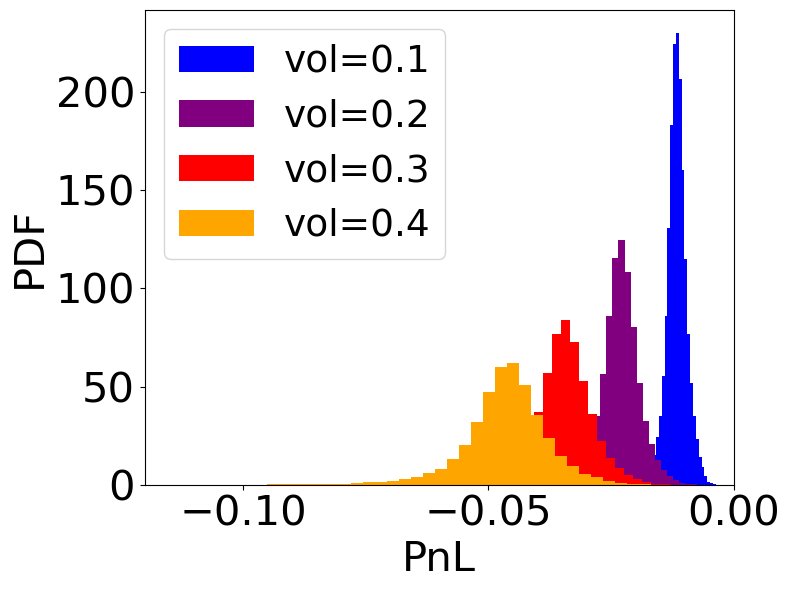

In [46]:
colors = ['blue','purple','red','orange']
vol = [0.1,0.2,0.3,0.4]
pnl_statistics = {}
plt.figure(figsize=[8,6])
for i in range(len(colors)):
    df_pnl = pd.DataFrame.from_dict(pnl_list[i][key_list[index]])
    plt.hist(df_pnl, bins=50, label='vol='+str(vol[i]), alpha=1.,color=colors[i],density = True)
plt.legend()
plt.xlim([-0.12,0.])
plt.legend(markerscale=5,fontsize=27,loc='upper left')
plt.xlabel('PnL',size=30)
plt.ylabel('PDF',size=30)
plt.xticks([-0.1,-0.05,0.0],fontsize = 30)
plt.yticks(fontsize = 30)
plt.tight_layout()

In [86]:
def compute_payoff(n_sims, strike, paths):
    payoff = np.zeros((n_sims,))
    #for k in paths.keys():
    v = paths['ADS']
    payoff -= np.maximum(v[-1,:] - strike,0)
    return payoff

In [94]:

sim_results, emb_vec = repo.simulate_model('ADS', n_sims=10000, days = 30, freq='D',model= GBM(drift=0.0, volatility=0.25),emb=4)
hedge_ins = {}
hedge_ins['ADS'] = sim_results

additional_states_ = {}
additional_states_["emb_key"] = emb_vec

paths = {}
paths.update(hedge_ins)
paths.update(additional_states_) 
payoff = compute_payoff(10000,1.,paths)

                    

In [95]:
sim_results, emb_vec = repo.simulate_model('ADS', n_sims=64000, days = 30, freq='D',model= GBM(drift=0.0, volatility=0.25),emb=4)
hedge_ins = {}
hedge_ins['ADS'] = sim_results

additional_states_ = {}
additional_states_["emb_key"] = emb_vec

paths_test = {}
paths_test.update(hedge_ins)
paths_test.update(additional_states_) 
payoff_test = compute_payoff(64000,1.,paths_test)

In [96]:
model_10000, embedding = get_hedge_model_and_embedding(ref_keys)
emb_layer = model_10000[key_list[index]].model.get_layer('Embedding')
print(emb_layer.get_weights())
pnl_pred, pnl_test,delta_test, loss_test = model_10000[key_list[index]].train_task(model=model_10000[key_list[index]],paths=paths, payoff=payoff,paths_test=paths_test, payoff_test=payoff_test)

[array([[-0.14114127],
       [-0.04930353],
       [ 0.02683642],
       [ 0.10379399],
       [ 0.03355874]], dtype=float32)]
<keras.engine.input_layer.InputLayer object at 0x000001966322CAD0> input_1 False
<keras.engine.input_layer.InputLayer object at 0x0000019656298D10> ADS False
<keras.engine.input_layer.InputLayer object at 0x000001965100EB90> ttm False
<keras.layers.core.embedding.Embedding object at 0x000001966322F610> Embedding True
<keras.layers.merging.concatenate.Concatenate object at 0x0000019654D66050> concatenate False
<keras.layers.reshaping.flatten.Flatten object at 0x000001966322DCD0> flatten False
<keras.layers.merging.concatenate.Concatenate object at 0x000001966322F390> concatenate_1 False
<keras.layers.core.dense.Dense object at 0x000001966324A090> dense False
<keras.layers.core.dense.Dense object at 0x000001965257B350> dense_1 False
<keras.layers.core.dense.Dense object at 0x0000019652AA8FD0> dense_2 False
<keras.layers.core.dense.Dense object at 0x0000019652ABB

In [100]:
delta_new = delta_test.reshape((-1,))

In [101]:
timegrid = VanillaOptionDeepHedgingPricer._compute_timegrid(days=30,freq='D')
model_025 = GBM(drift=0.0, volatility=0.25)
delta_BS_025 = model_025.compute_BS_delta(paths_test['ADS'][t,:],timegrid)


In [120]:
repo = analysis.Repo('./singletask_GBM_vanillacalloption/')
key_list_ST = list(repo.results.keys())

In [110]:

repo.results[key_list_ST[40]]

{'val_date': '2023-01-01T00:00:00',
 'spec': [{'id': 'Test_Call1',
   'issuer': 'DBK',
   'sec_lvl': 'COLLATERALIZED',
   'curr': 'EUR',
   'udl_id': 'ADS',
   'type': 'CALL',
   'expiry': '2023-01-31T00:00:00',
   'strike': 1.0,
   'share_ratio': 1,
   'long_short_flag': 'long',
   'cls': 'EuropeanVanillaSpecification'}],
 'model': [{'drift': 0.0, 'volatility': 0.25, 'cls': 'GBM'}],
 'pricing_param': {'depth': 3,
  'nb_neurons': 64,
  'n_sims': 10000,
  'regularization': 0.0,
  'epochs': 1000,
  'verbose': 1,
  'tensorboard_logdir': 'logs/20240626T172127',
  'initial_lr': 0.005,
  'decay_steps': 16000,
  'batch_size': 256,
  'decay_rate': 0.95,
  'seed': 0,
  'days': 30,
  'embedding_size': 1},
 'spec_hash': {'Test_Call1': 'c256412e687a022f6453d9a3f2095801befda8f4'},
 'model_hash': {'GBM': 'd9b7606c19e32707ca553822bcbb7ea3a6ba1ee5'},
 'pricing_params_hash': '4a1ffe7272e25cff3e17b2c5658a556aeef0d7eb',
 'pnl_result': {'mean': -0.028446848574389713,
  'var': 3.33102005301309e-05,
  'loss

In [121]:
experiments = {}
key_list_ST = []
for k,v in repo.results.items():  
        key_list_ST.append(k)

In [113]:
index = 40

In [116]:
tmp={
        'ref_keys':key_list_ST[index],#key_list[0]
        'labels':{ key_list_ST[index]: 'GBMonly'                
        }
}
experiments['GBMonly'] = tmp

experiment = 'GBMonly'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
#labels_T = {k:v for v,k in labels.items()}
#loop = 4
#model_list = []
#for i in range(loop):
#    model_list.append(HestonForDeepHedging(rate_of_mean_reversion = model_params['Heston']['rate_of_mean_reversion'][i],
#                                      long_run_average = model_params['Heston']['long_run_average'][i],
#                                      vol_of_vol = model_params['Heston']['vol_of_vol'][i], 
#                                      correlation_rho = model_params['Heston']['correlation_rho'][i],
#                                      v0 = model_params['Heston']['v0'][i]))
model_list_single = [GBM(drift=0.0, volatility=0.25)]
sim_results_list_single = []
paths_list_single = []
pnl_list_single = []
delta_list_single = []
hedge_model_list_single = []


count = 0
n_sims = 64000
t = 28
print('get hedge model and embedding')
hedge_model, embedding = get_hedge_model_and_embedding(ref_keys)
embedding
print('get specs')
specs = get_specs(ref_keys)
print('get sim_results, paths, pnl and delta for model:')
for i in model_list_single:
    hedge_model_list_single.append(hedge_model)
    sim_results, paths = get_sim_results_and_paths(ref_keys,i,count,n_sims)
    sim_results_list_single.append(sim_results)
    paths_list_single.append(paths)
    pnl = get_pnl(hedge_model, specs, paths_list_single[count], n_sims)
    delta = get_delta(hedge_model_list_single[count], t, paths_list_single[count],count)
    pnl_list_single.append(pnl)
    delta_list_single.append(delta)
    count = count + 1


get hedge model and embedding
get specs
get sim_results, paths, pnl and delta for model:
2000/2000 [==============================] - 1s 698us/step


In [124]:
paths_list_single

[{'4719e4e745cea568379727ca48945c6555b1cfd9': {'ADS': array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
           1.        ],
          [1.00654367, 0.99193583, 0.99355482, ..., 0.99734393, 1.00566319,
           1.01478317],
          [1.00460415, 1.01660342, 0.99101501, ..., 1.01566598, 1.00896916,
           1.0123394 ],
          ...,
          [0.93638674, 0.93402669, 1.00288837, ..., 0.93376406, 1.1658413 ,
           0.93824249],
          [0.92884876, 0.93807071, 0.99575394, ..., 0.90872761, 1.16397671,
           0.95106054],
          [0.92516779, 0.95024571, 1.00249065, ..., 0.89855976, 1.19100398,
           0.96780319]]),
   'emb_key': array([0., 0., 0., ..., 0., 0., 0.])}}]

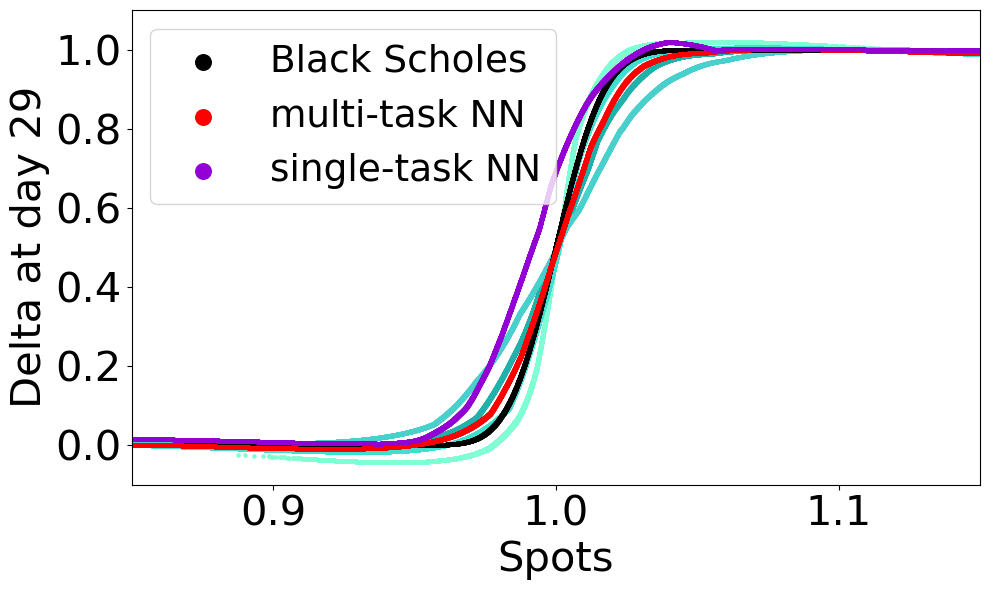

In [137]:
colors = ['aquamarine','turquoise','lightseagreen','mediumturquoise']
vol = [0.1,0.2,0.3,0.4]
index = 0
plt.figure(figsize=[10,6])
for i in range(len(colors)):
    paths = paths_list[i][key_list[index]]['ADS'][t,:]
    df_delta = delta_list[i][key_list[index]]
    plt.scatter(x = paths_list[i][key_list[index]]['ADS'][t,:], y =delta_list[i][key_list[index]], s = 5, alpha=1.,color=colors[i])
plt.scatter(x = paths_test['ADS'][t,:], y = delta_BS_025, label ='Black Scholes', color = 'black',s = 5)
plt.scatter(x = paths_test['ADS'][t,:], y =delta_new, s = 5,label='multi-task NN', alpha=1.,color='red')
plt.scatter(x = paths_test['ADS'][t,:], y =delta_list_single[0][key_list_ST[40]], s = 5,label='single-task NN', alpha=1.,color='darkviolet')
plt.xlim([0.85,1.15])
plt.ylim([-0.1,1.1])
plt.legend(markerscale=5,fontsize=27,loc='upper left')
plt.xlabel('Spots',size=30)
plt.ylabel('Delta at day 29',size=30)
plt.xticks([0.9,1.,1.1],fontsize = 30)
plt.yticks([0.,0.2,0.4,0.6,0.8,1.0],fontsize = 30)
plt.tight_layout()


In [133]:
emb_layer = model_10000[key_list[index]].model.get_layer('Embedding')
print(emb_layer.get_weights())

[array([[-0.14114127],
       [-0.04930353],
       [ 0.02683642],
       [ 0.10379399],
       [-0.00436936]], dtype=float32)]


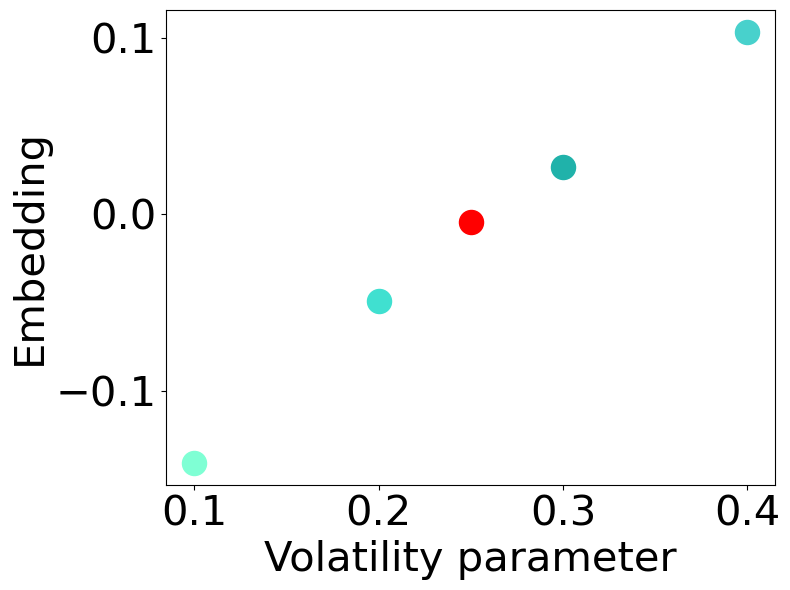

In [134]:
(w,) = emb_layer.get_weights()
vol = [0.1,0.2,0.3,0.4,0.25]
colors =  ['aquamarine','turquoise','lightseagreen','mediumturquoise','red']
plt.figure(figsize=[8,6])
for i in range(len(colors)):
    plt.scatter(vol[i],w[i],s=300.,c=colors[i])
plt.xlabel('Volatility parameter',size=30)
plt.ylabel('Embedding',size=30)
plt.xticks([0.1,0.2,0.3,0.4],fontsize = 30)
plt.yticks([-0.1,0.,0.1],fontsize = 30)
plt.tight_layout()

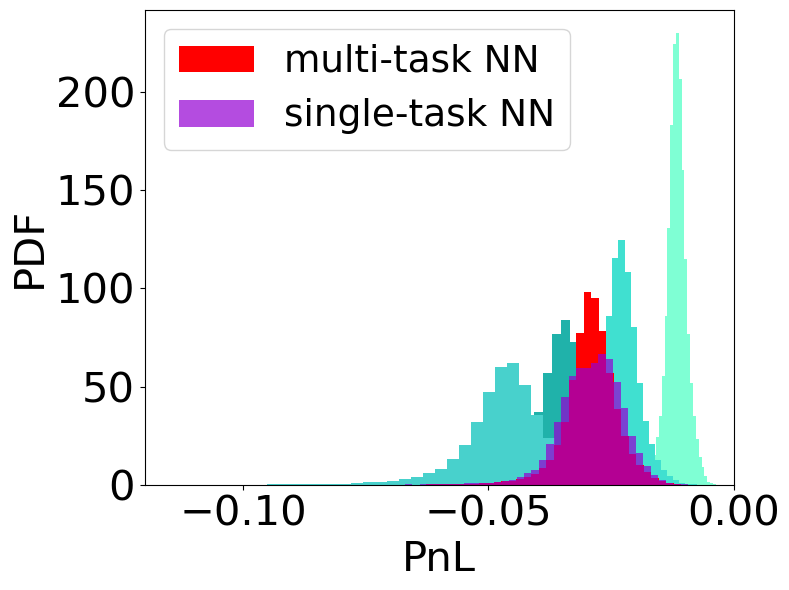

In [141]:
vol = [0.1,0.2,0.3,0.4,0.25]
colors =  ['aquamarine','turquoise','lightseagreen','mediumturquoise','red']
pnl_statistics = {}
plt.figure(figsize=[8,6])
for i in range(len(colors)-1):
    df_pnl = pd.DataFrame.from_dict(pnl_list[i][key_list[index]])
    plt.hist(df_pnl, bins=50, alpha=1.,color=colors[i],density = True)
plt.hist(pnl_test,bins=50, label='multi-task NN', alpha=1.,color='red',density = True)
plt.hist(pnl_list_single[0][key_list_ST[40]],bins=50, label='single-task NN', alpha=.7,color='darkviolet',density = True)
plt.legend()
plt.xlim([-0.12,0.])
plt.legend(markerscale=5,fontsize=27,loc='upper left')
plt.xlabel('PnL',size=30)
plt.ylabel('PDF',size=30)
plt.xticks([-0.1,-0.05,0.0],fontsize = 30)
plt.yticks(fontsize = 30)
plt.tight_layout()

# Heston

In [242]:
repo = analysis.Repo('./multitask_heston_vanillacalloption/')
key_list = list(repo.results.keys())

In [243]:
experiments = {}
key_list = []
for k,v in repo.results.items():  
        key_list.append(k)

In [244]:
repo.results[key_list[64]]['pricing_param']

{'depth': 3,
 'nb_neurons': 64,
 'n_sims': 2048000,
 'regularization': 10.0,
 'epochs': 10,
 'verbose': 1,
 'tensorboard_logdir': 'logs/20240625T191132',
 'initial_lr': 0.005,
 'decay_steps': 16000,
 'batch_size': 1024,
 'decay_rate': 0.95,
 'seed': 0,
 'days': 30,
 'embedding_size': 5,
 'transaction_cost': {'ADS': [0.01]},
 'loss': 'exponential_utility'}

In [245]:
index = 64

In [246]:
import ast  
with open('model_params_dict.txt') as f: 
    data = f.read() 
model_params = ast.literal_eval(data) 

In [247]:
choice = 47

In [256]:
tmp={
        'ref_keys':key_list[index],#key_list[0]
        'labels':{ key_list[index]: 'Hestononly'                
        }
}
experiments['Hestononly'] = tmp

experiment = 'Hestononly'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
#labels_T = {k:v for v,k in labels.items()}
loop = 128
model_list = []
for i in range(loop):
    model_list.append(HestonForDeepHedging(rate_of_mean_reversion = model_params['Heston']['rate_of_mean_reversion'][i],
                                      long_run_average = model_params['Heston']['long_run_average'][i],
                                      vol_of_vol = model_params['Heston']['vol_of_vol'][i], 
                                      correlation_rho = model_params['Heston']['correlation_rho'][i],
                                      v0 = model_params['Heston']['v0'][i]))
#model_list = [GBM(drift=0.0, volatility=0.1), GBM(drift=0.0, volatility=0.2),GBM(drift=0.0, volatility=0.3),GBM(drift=0.0, volatility=0.4)]
sim_results_list = []
paths_list = []
pnl_list = []
delta_list = []
hedge_model_list = []
price_list = []


count = 0
n_sims = 64000
t = 28
print('get hedge model and embedding')
hedge_model, embedding = get_hedge_model_and_embedding(ref_keys)
print('get specs')
specs = get_specs(ref_keys)
print('get sim_results, paths, pnl and delta for model:')
for i in model_list:
    hedge_model_list.append(hedge_model)
    sim_results, paths = get_sim_results_and_paths(ref_keys,i,count,n_sims)
    sim_results_list.append(sim_results)
    if count == choice:
        paths_list.append(paths)
        pnl = get_pnl(hedge_model, specs, paths_list[0], n_sims)
        delta = get_delta(hedge_model_list[count], t, paths_list[0],count)
        pnl_list.append(pnl)
        delta_list.append(delta)
    price = get_price(ref_keys,i,n_sims,sim_results=sim_results)
    price_list.append(price)
    count = count + 1




get hedge model and embedding
get specs
get sim_results, paths, pnl and delta for model:
2000/2000 [==============================] - 2s 949us/step


In [257]:
def compute_payoff(n_sims, strike, paths):
    payoff = np.zeros((n_sims,))
    #for k in paths.keys():
    v = paths['ADS']
    payoff -= np.maximum(v[-1,:] - strike,0)
    return payoff

In [258]:
model1 = model_list[choice]

In [259]:

sim_results, emb_vec = repo.simulate_model('ADS', n_sims=10000, days = 30, freq='D',model=model1,emb=128)
hedge_ins = {}
hedge_ins['ADS'] = sim_results

additional_states_ = {}
additional_states_["emb_key"] = emb_vec

paths = {}
paths.update(hedge_ins)
paths.update(additional_states_) 
payoff = compute_payoff(10000,1.,paths)

                    

In [260]:

sim_results, emb_vec = repo.simulate_model('ADS', n_sims=64000, days = 30, freq='D',model= model1,emb=128)
sim_results = sim_results_list[choice][key_list[64]]
hedge_ins = {}
hedge_ins['ADS'] = sim_results

additional_states_ = {}
additional_states_["emb_key"] = emb_vec

paths_test = {}
paths_test.update(hedge_ins)
paths_test.update(additional_states_) 
payoff_test = compute_payoff(64000,1.,paths_test)

                    

In [261]:
model_test1, embedding = get_hedge_model_and_embedding(ref_keys)
emb_layer = model_test1[key_list[index]].model.get_layer('Embedding')
print(emb_layer.get_weights())
pnl_pred, pnl_test,delta_test, loss_train = model_test1[key_list[index]].train_task(model=model_test1[key_list[index]],paths=paths, payoff=payoff,paths_test=paths_test, payoff_test=payoff_test)

[array([[ 2.58446187e-01,  5.59882112e-02, -9.94120955e-01,
         1.92405790e-01, -6.60305768e-02],
       [-9.85897519e-03, -5.14788786e-03, -8.60578299e-01,
        -1.19386718e-01, -3.71597633e-02],
       [-3.25037912e-02,  4.19807844e-02, -6.61010981e-01,
        -1.28491208e-01,  1.10782512e-01],
       [-9.93356481e-02, -7.36249378e-03, -6.18381381e-01,
        -1.09043248e-01, -3.35504450e-02],
       [ 6.90173879e-02,  7.13448599e-02, -5.57115912e-01,
        -1.63178235e-01,  1.76552567e-04],
       [ 1.20360442e-01,  6.80521131e-02, -4.19217497e-01,
         3.82442563e-03, -1.54584199e-01],
       [-1.97096974e-01,  7.93425599e-04, -3.40514600e-01,
        -5.22867441e-02,  3.61056514e-02],
       [-3.88028920e-02,  8.55043903e-02, -1.73992962e-01,
         2.65005231e-01,  2.47878097e-02],
       [ 1.36905955e-02, -9.60259363e-02, -5.76348156e-02,
        -5.22893295e-03, -1.15993917e-01],
       [-3.24992388e-02, -6.64369315e-02, -3.29026692e-02,
        -1.10510290e-0

In [262]:
emb_layer = model_test1[key_list[index]].model.get_layer('Embedding')
(w_new,) = emb_layer.get_weights()

C:\Users\Anwender\AppData\Local\Temp\ipykernel_9140\820894471.py:17: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored

C:\Users\Anwender\AppData\Local\Temp\ipykernel_9140\820894471.py:19: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored



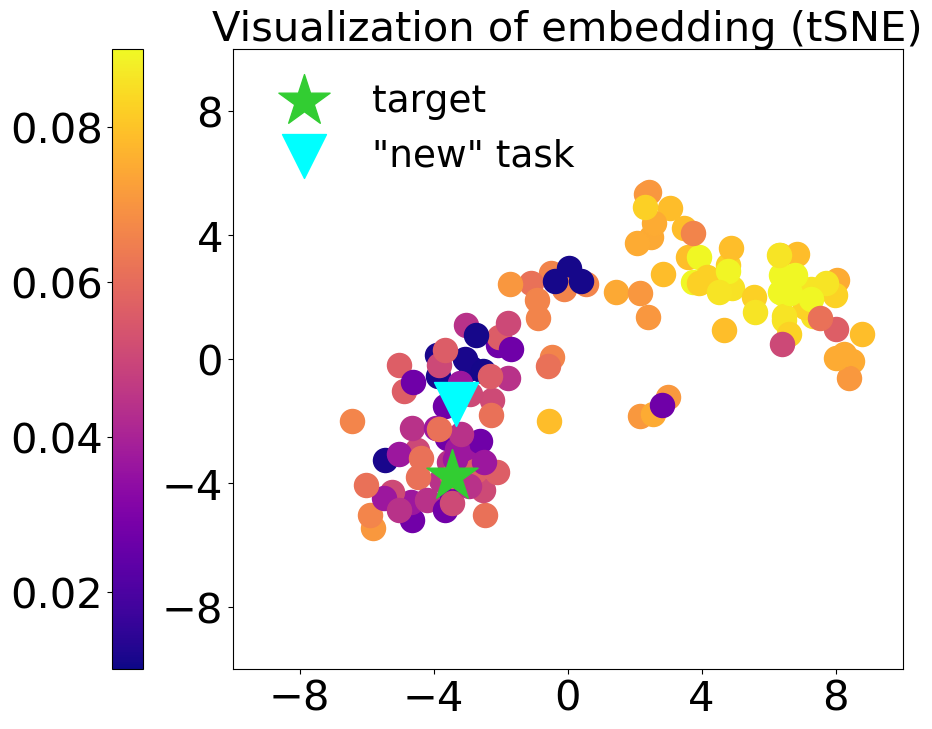

In [263]:
(w_new,) = emb_layer.get_weights()
y_subset = list(range(1, len(model_list)))
y_subset.append(128)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42,n_iter=15000, metric="cosine")
X_umap = tsne.fit_transform(w_new,y_subset)

plt.figure(figsize=[10,8])
for i in range(len(model_list)):
    n = y_subset[i]
    sc = plt.scatter(X_umap[i, 0], X_umap[i, 1],c =price_list[i],vmin=0.01, vmax=0.09,cmap='plasma',s=300) 
#i = 4
#plt.scatter(X_umap[i, 0], X_umap[i, 1],c ='green',vmin=0.01, vmax=0.09,cmap='plasma',s=1000,label='p=0.4',marker='*')
#i = 13
#plt.scatter(X_umap[i, 0], X_umap[i, 1],c ='green',vmin=0.01, vmax=0.09,cmap='plasma',s=1000,label='p=0.4',marker='*')
i = choice
plt.scatter(X_umap[i, 0], X_umap[i, 1],c ='limegreen',vmin=0.01, vmax=0.09,cmap='plasma',s=1500,marker='*',label='target')
i = -1
plt.scatter(X_umap[i, 0], X_umap[i, 1],c ='cyan',vmin=0.01, vmax=0.09,cmap='plasma',s=1000,marker='v',label='"new" task')
#i = 8
#plt.scatter(X_umap[i, 0], X_umap[i, 1],c =price_list[i],vmin=0.01, vmax=0.09,cmap='plasma',s=300,label='p=0.7')  
cb = plt.colorbar(sc,location='left')#.set_ticks([])
plt.title('Visualization of embedding (tSNE)',size=30)
plt.ylim([-10,10])
plt.xlim([-10,10])
plt.xticks([-8,-4,0,4,8],fontsize = 30)
plt.yticks([-8,-4,0,4,8],fontsize = 30)
legend=plt.legend(fontsize=27,loc='upper left')
plt.rc('font', **{'size':'30'})
legend.get_frame().set_alpha(0.)
plt.tight_layout()
plt.show()





In [264]:
delta_new = delta_test.reshape((-1,))

In [265]:
repo = analysis.Repo('./test_ins/')
key_list_ST = list(repo.results.keys())

In [266]:
experiments = {}
key_list_ST = []
for k,v in repo.results.items():  
        key_list_ST.append(k)

In [267]:
index = -1

In [268]:
repo.results[key_list_ST[index]]['pnl_result']

{'mean': -0.05819241940614116,
 'var': 0.0009993482385647523,
 'loss': 0.06336456537246704,
 '1%': -0.14584752245502758,
 '99%': -0.004730910730755395,
 '5%': -0.11758965531723728,
 '95%': -0.013803962089380296}

In [269]:
tmp={
        'ref_keys':key_list_ST[index],#key_list[0]
        'labels':{ key_list_ST[index]: 'Hestononly'                
        }
}
experiments['Hestononly'] = tmp

experiment = 'Hestononly'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
#labels_T = {k:v for v,k in labels.items()}
#loop = 4
#model_list = []
#for i in range(loop):
#    model_list.append(HestonForDeepHedging(rate_of_mean_reversion = model_params['Heston']['rate_of_mean_reversion'][i],
#                                      long_run_average = model_params['Heston']['long_run_average'][i],
#                                      vol_of_vol = model_params['Heston']['vol_of_vol'][i], 
#                                      correlation_rho = model_params['Heston']['correlation_rho'][i],
#                                      v0 = model_params['Heston']['v0'][i]))
model_list_single = []
import ast  
with open('model_params_dict.txt') as f: 
    data = f.read() 
model_params = ast.literal_eval(data) 

loop = 1#len(vol_list)
for i in [13]:#range(loop):
    #model.append(GBM(0.,vol_list[i]))
    #model.append(GBM(drift=model_params['GBM']['drift'][i],volatility=model_params['GBM']['vol'][i]))
    model_list_single.append(HestonForDeepHedging(rate_of_mean_reversion = model_params['Heston']['rate_of_mean_reversion'][i],
                                      long_run_average = model_params['Heston']['long_run_average'][i],
                                      vol_of_vol = model_params['Heston']['vol_of_vol'][i], 
                                      correlation_rho = model_params['Heston']['correlation_rho'][i],
                                      v0 = model_params['Heston']['v0'][i]))
sim_results_list_single = []
paths_list_single = []
pnl_list_single = []
delta_list_single = []
hedge_model_list_single = []
loss_list_single = []


count = 0
n_sims = 64000
t = 28
print('get hedge model and embedding')
hedge_model, embedding = get_hedge_model_and_embedding(ref_keys)
embedding
print('get specs')
specs = get_specs(ref_keys)
print('get sim_results, paths, pnl and delta for model:')
for i in model_list_single:
    hedge_model_list_single.append(hedge_model)
    sim_results, paths = get_sim_results_and_paths(ref_keys,i,count,n_sims)
    sim_results_list_single.append(sim_results)
    paths_list_single.append(paths)
    pnl = get_pnl(hedge_model, specs, paths_list_single[count], n_sims)
    delta = get_delta(hedge_model_list_single[count], t, paths_list_single[count],count)
    pnl_list_single.append(pnl)
    delta_list_single.append(delta)
    count = count + 1


get hedge model and embedding
get specs
get sim_results, paths, pnl and delta for model:
2000/2000 [==============================] - 2s 1ms/step


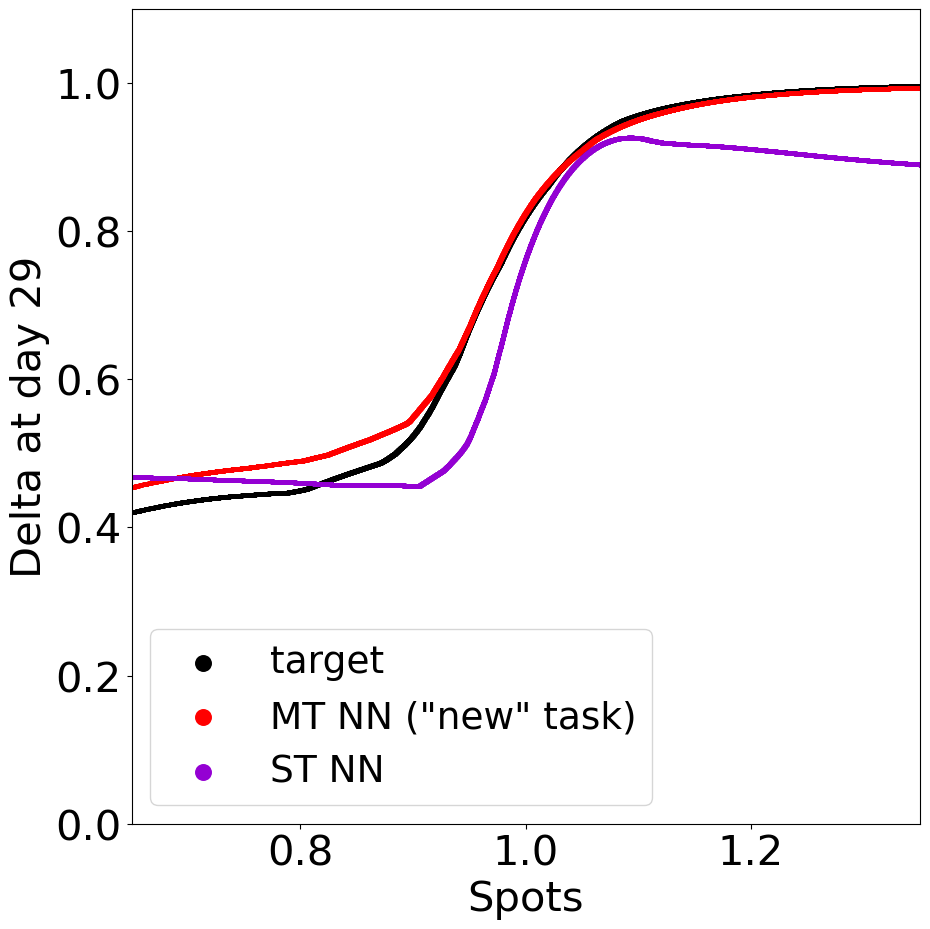

In [270]:
colors = ['aquamarine','turquoise','lightseagreen','mediumturquoise']
vol = [0.1,0.2,0.3,0.4]
plt.figure(figsize=[10,10])
plt.scatter(x = paths_list[0][key_list[64]]['ADS'][t,:], y =delta_list[0][key_list[64]], s = 5,label='target', alpha=1.,color='black')
plt.scatter(x = paths_list[0][key_list[64]]['ADS'][t,:], y =delta_new, s = 5,label='MT NN ("new" task)', alpha=1.,color='red')
plt.scatter(x = paths_list_single[0][key_list_ST[-1]]['ADS'][t,:], y =delta_list_single[0][key_list_ST[-1]], s = 5,label='ST NN', alpha=1.,color='darkviolet')
plt.xlim([0.65,1.35])
plt.ylim([0.,1.1])
plt.legend(markerscale=5,fontsize=27,loc='lower left')
plt.xlabel('Spots',size=30)
plt.ylabel('Delta at day 29',size=30)
#plt.xticks([0.9,1.,1.1],fontsize = 30)
#plt.yticks([0.,0.4,0.8],fontsize = 30)
plt.tight_layout()


In [237]:
price_list[choice]

0.05634032618249286

In [236]:
from scipy.stats import skew 
print('target:',pnl_list[0][key_list[64]].mean(),pnl_list[0][key_list[64]].var(),skew(pnl_list[0][key_list[64]]))
print('MT:',pnl_test.mean(),pnl_test.var(),skew(pnl_test))
print('ST:',pnl_list_single[0][key_list_ST[-1]].mean(),pnl_list_single[0][key_list_ST[-1]].var(),skew(pnl_list_single[0][key_list_ST[-1]]))

target: -0.05913124778483509 0.0010131379292321223 -0.535851044831389
MT: -0.059528646871107434 0.000936872750003547 -0.5433438689829582
ST: -0.09369439223001919 0.002218383796370513 -0.595476732084235


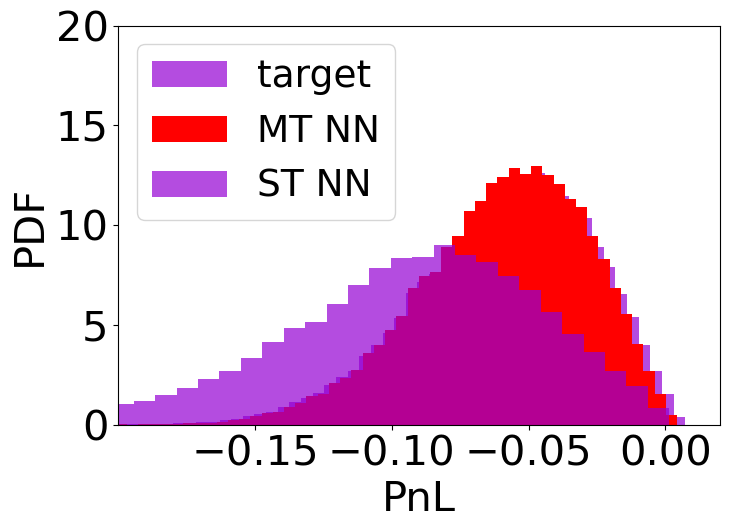

In [234]:
vol = [0.1,0.2,0.3,0.4,0.25]
colors =  ['aquamarine','turquoise','lightseagreen','mediumturquoise','red']
pnl_statistics = {}
plt.figure(figsize=[8,6])
plt.hist(pnl_list[0][key_list[64]],bins=50, label='target', alpha=.7,color='darkviolet',density = True)
plt.hist(pnl_test,bins=50, label='MT NN', alpha=1.,color='red',density = True)
plt.hist(pnl_list_single[0][key_list_ST[-1]],bins=50, label='ST NN', alpha=.7,color='darkviolet',density = True)
plt.legend()
plt.xlim([-0.2,0.02])
plt.legend(markerscale=5,fontsize=27,loc='upper left')
plt.xlabel('PnL',size=30)
plt.ylabel('PDF',size=30)
plt.xticks([-0.15,-0.1,-0.05,0.0],fontsize = 30)
plt.yticks([0.,5.,10.,15.,20.],fontsize = 30)
plt.tight_layout()

In [41]:
repo = analysis.Repo('./multitask_heston_vanillacalloption/')
key_list = list(repo.results.keys())

In [42]:
experiments = {}
key_list = []
for k,v in repo.results.items():  
        key_list.append(k)

In [43]:
index_list = []
for i in range(len(key_list)):
    tc = repo.results[key_list[i]]['pricing_param']['transaction_cost']['ADS'][0]
    seed = repo.results[key_list[i]]['pricing_param']['seed']
    emb = repo.results[key_list[i]]['pricing_param']['embedding_size']
    if tc == 0.01 and seed == 0 and (emb == 5 or emb == 2 or emb == 10):
        index_list.append(i)


In [44]:
for index in index_list:
    name = 'emb'+str(repo.results[key_list[index]]['pricing_param']['embedding_size'])+'seed'+str(repo.results[key_list[index]]['pricing_param']['seed'])               
    tmp={
        'ref_keys':key_list[index],
        'labels':{ key_list[index]: name
        }
    }
    experiments[name] = tmp

In [45]:
experiments.keys()

dict_keys(['emb2seed0', 'emb5seed0', 'emb10seed0'])

In [46]:
def compute_payoff(n_sims, strike, paths):
    payoff = np.zeros((n_sims,))
    #for k in paths.keys():
    v = paths['ADS']
    payoff -= np.maximum(v[-1,:] - strike,0)
    return payoff

In [47]:

sim_results, emb_vec = repo.simulate_model('ADS', n_sims=64000, days = 30, freq='D',model= HestonForDeepHedging(rate_of_mean_reversion = 0.6067,long_run_average = 0.0707,
                  vol_of_vol = 0.2928, correlation_rho = -0.757,v0 = 0.0654),emb=128)
hedge_ins = {}
hedge_ins['ADS'] = sim_results

additional_states_ = {}
additional_states_["emb_key"] = emb_vec

paths_test = {}
paths_test.update(hedge_ins)
paths_test.update(additional_states_) 
payoff_test = compute_payoff(64000,1.,paths_test)

                    

In [48]:
pnl_retrain = {}
delta_retrain = {}
loss_retrain = {}
for index in experiments.keys():
    ref_keys = experiments[index]['ref_keys']
    for n_sims in [2,10,100,1000,10000,64000]:
        sim_results, emb_vec = repo.simulate_model('ADS', n_sims=n_sims, days = 30, freq='D',model= HestonForDeepHedging(rate_of_mean_reversion = 0.6067,long_run_average = 0.0707,
                        vol_of_vol = 0.2928, correlation_rho = -0.757,v0 = 0.0654),emb=128)
        hedge_ins = {}
        hedge_ins['ADS'] = sim_results

        additional_states_ = {}
        additional_states_["emb_key"] = emb_vec

        paths = {}
        paths.update(hedge_ins)
        paths.update(additional_states_) 
        payoff = compute_payoff(n_sims,1.,paths)

        model_retrain, embedding = get_hedge_model_and_embedding(ref_keys)
        pnl_pred, pnl_test,delta_test, loss_train = model_retrain[ref_keys].train_task(model=model_retrain[ref_keys],paths=paths, payoff=payoff,paths_test=paths_test, payoff_test=payoff_test)
        pnl_retrain[str(index)+'n'+str(n_sims)] = pnl_test
        delta_retrain[str(index)+'n'+str(n_sims)] = delta_test
        loss_retrain[str(index)+'n'+str(n_sims)] = loss_train

<keras.engine.input_layer.InputLayer object at 0x0000015ED23FB310> input_24 False
<keras.engine.input_layer.InputLayer object at 0x0000015ED6661490> ADS False
<keras.engine.input_layer.InputLayer object at 0x0000015ED23FA510> ttm False
<keras.layers.core.embedding.Embedding object at 0x0000015ED23FA810> Embedding True
<keras.layers.merging.concatenate.Concatenate object at 0x0000015ED23FB410> concatenate_46 False
<keras.layers.reshaping.flatten.Flatten object at 0x0000015ED3B38850> flatten_23 False
<keras.layers.merging.concatenate.Concatenate object at 0x0000015ED3B3B8D0> concatenate_47 False
<keras.layers.core.dense.Dense object at 0x0000015ED3B3A550> dense_115 False
<keras.layers.core.dense.Dense object at 0x0000015EC7835810> dense_116 False
<keras.layers.core.dense.Dense object at 0x0000015EC72B2510> dense_117 False
<keras.layers.core.dense.Dense object at 0x0000015ECE693010> dense_118 False
<keras.layers.core.dense.Dense object at 0x0000015ECE5ABA90> dense_119 False
Epoch 1/10
1/1

In [116]:
from scipy.stats import skew 
for index in loss_retrain.keys():
    if 'emb5' in index:
        print(index, pnl_retrain[index].mean(), pnl_retrain[index].var(),skew(pnl_retrain[index]))

emb5seed0n2 -0.03069349030365662 0.0003469449331330568 -0.8016104840373606
emb5seed0n10 -0.030663761901738657 0.00034903599200705564 -0.8060709577509024
emb5seed0n100 -0.03037795688591392 0.00036801415706058383 -0.8245377717521101
emb5seed0n1000 -0.02977131393279375 0.0004178124734777496 -0.7758404426099935
emb5seed0n10000 -0.029728861298481537 0.0004211476631883012 -0.7849997279157556
emb5seed0n64000 -0.029693272586050045 0.0004217254591740331 -0.7800702241597055


In [102]:
repo = analysis.Repo('./test_ins/')
key_list_ST = list(repo.results.keys())

In [103]:
for ii in [-6,-5,-4,-3,-2,-1]:
    N = repo.results[key_list_ST[ii]]['pricing_param']['n_sims']
    L = repo.results[key_list_ST[ii]]['pnl_result']['loss']
    print(N,L)


10000 0.031029410660266876
2 nan
10 0.026399660855531693
100 0.028606191277503967
1000 0.03152932971715927
64000 0.03117535263299942


In [140]:
index = -1
tmp={
        'ref_keys':key_list_ST[index],#key_list[0]
        'labels':{ key_list_ST[index]: 'Hestononly'                
        }
}
experiments['Hestononly'] = tmp

experiment = 'Hestononly'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
#labels_T = {k:v for v,k in labels.items()}
#loop = 4
#model_list = []
#for i in range(loop):
#    model_list.append(HestonForDeepHedging(rate_of_mean_reversion = model_params['Heston']['rate_of_mean_reversion'][i],
#                                      long_run_average = model_params['Heston']['long_run_average'][i],
#                                      vol_of_vol = model_params['Heston']['vol_of_vol'][i], 
#                                      correlation_rho = model_params['Heston']['correlation_rho'][i],
#                                      v0 = model_params['Heston']['v0'][i]))
model_list_single = [HestonForDeepHedging(rate_of_mean_reversion = 0.6067,long_run_average = 0.0707,
                  vol_of_vol = 0.2928, correlation_rho = -0.757,v0 = 0.0654)]
sim_results_list_single = []
paths_list_single = []
pnl_list_single = []
delta_list_single = []
hedge_model_list_single = []
loss_list_single = []


count = 0
n_sims = 64000
t = 28
print('get hedge model and embedding')
hedge_model, embedding = get_hedge_model_and_embedding(ref_keys)
embedding
print('get specs')
specs = get_specs(ref_keys)
print('get sim_results, paths, pnl and delta for model:')
for i in model_list_single:
    hedge_model_list_single.append(hedge_model)
    sim_results, paths = get_sim_results_and_paths(ref_keys,i,count,n_sims)
    sim_results_list_single.append(sim_results)
    paths_list_single.append(paths)
    pnl = get_pnl(hedge_model, specs, paths_list_single[count], n_sims)
    delta = get_delta(hedge_model_list_single[count], t, paths_list_single[count],count)
    pnl_list_single.append(pnl)
    delta_list_single.append(delta)
    count = count + 1


get hedge model and embedding
get specs
get sim_results, paths, pnl and delta for model:
2000/2000 [==============================] - 2s 932us/step


In [141]:
print(pnl[ref_keys].mean(), pnl[ref_keys].var(),skew(pnl[ref_keys]))

-0.02971039702005179 0.000409031881684644 -0.6086159405894894


In [106]:
index = -2
tmp={
        'ref_keys':key_list_ST[index],#key_list[0]
        'labels':{ key_list_ST[index]: 'Hestononly'                
        }
}
experiments['Hestononly'] = tmp

experiment = 'Hestononly'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
#labels_T = {k:v for v,k in labels.items()}
#loop = 4
#model_list = []
#for i in range(loop):
#    model_list.append(HestonForDeepHedging(rate_of_mean_reversion = model_params['Heston']['rate_of_mean_reversion'][i],
#                                      long_run_average = model_params['Heston']['long_run_average'][i],
#                                      vol_of_vol = model_params['Heston']['vol_of_vol'][i], 
#                                      correlation_rho = model_params['Heston']['correlation_rho'][i],
#                                      v0 = model_params['Heston']['v0'][i]))
model_list_single = [HestonForDeepHedging(rate_of_mean_reversion = 0.6067,long_run_average = 0.0707,
                  vol_of_vol = 0.2928, correlation_rho = -0.757,v0 = 0.0654)]
sim_results_list_single = []
paths_list_single_1000 = []
pnl_list_single = []
delta_list_single_1000 = []
hedge_model_list_single = []
loss_list_single = []


count = 0
n_sims = 64000
t = 28
print('get hedge model and embedding')
hedge_model, embedding = get_hedge_model_and_embedding(ref_keys)
embedding
print('get specs')
specs = get_specs(ref_keys)
print('get sim_results, paths, pnl and delta for model:')
for i in model_list_single:
    hedge_model_list_single.append(hedge_model)
    sim_results, paths = get_sim_results_and_paths(ref_keys,i,count,n_sims)
    sim_results_list_single.append(sim_results)
    paths_list_single_1000.append(paths)
    pnl = get_pnl(hedge_model, specs, paths_list_single_1000[count], n_sims)
    delta = get_delta(hedge_model_list_single[count], t, paths_list_single_1000[count],count)
    pnl_list_single.append(pnl)
    delta_list_single_1000.append(delta)
    count = count + 1


get hedge model and embedding
get specs
get sim_results, paths, pnl and delta for model:
2000/2000 [==============================] - 2s 809us/step


In [54]:
loss_retrain

{'emb2seed0n2': 0.03250744566321373,
 'emb2seed0n10': 0.03252173960208893,
 'emb2seed0n100': 0.032402876764535904,
 'emb2seed0n1000': 0.031900517642498016,
 'emb2seed0n10000': 0.031892627477645874,
 'emb2seed0n64000': 0.03189109265804291,
 'emb5seed0n2': 0.03245246782898903,
 'emb5seed0n10': 0.032434094697237015,
 'emb5seed0n100': 0.032249193638563156,
 'emb5seed0n1000': 0.031895749270915985,
 'emb5seed0n10000': 0.031871795654296875,
 'emb5seed0n64000': 0.031838204711675644,
 'emb10seed0n2': 0.03246240317821503,
 'emb10seed0n10': 0.03249436244368553,
 'emb10seed0n100': 0.03224176540970802,
 'emb10seed0n1000': 0.0318576917052269,
 'emb10seed0n10000': 0.03181268647313118,
 'emb10seed0n64000': 0.03179631382226944}

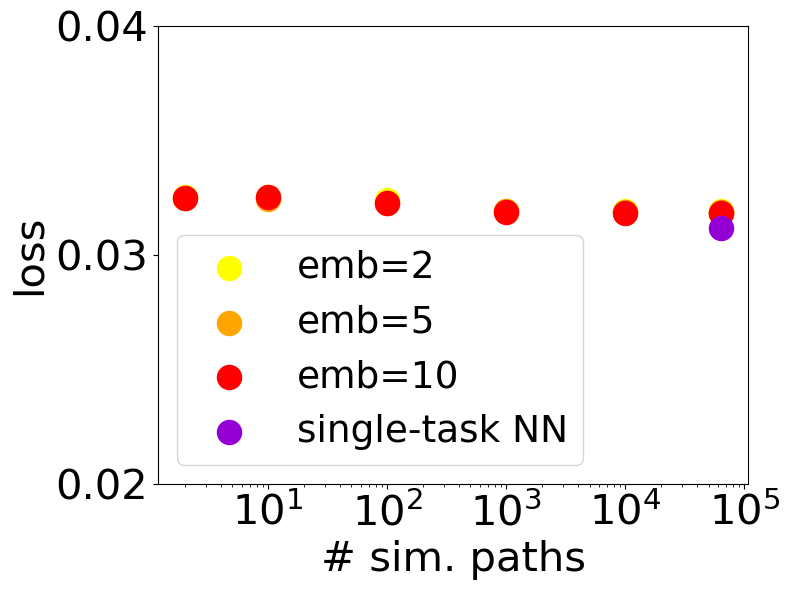

In [58]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

n_sims_list = [2,10,100,1000,10000,64000,2,10,100,1000,10000,64000,2,10,100,1000,10000,64000]
colors = ['yellow','yellow','yellow','yellow','yellow','yellow','orange','orange','orange','orange','orange','orange','red','red','red','red','red','red']
emb = [2,2,2,2,2,2,5,5,5,5,5,5,10,10,10,10,10,10]
count = 0
plt.figure(figsize=[8,6])
for index in loss_retrain.keys():
    plt.scatter(n_sims_list[count],loss_retrain[index],color=colors[count],s=300.)
    count = count + 1
count = 5
plt.scatter(n_sims_list[count],loss_retrain[index],color=colors[count],s=300.,label='emb='+str(emb[count]))
count = 11
plt.scatter(n_sims_list[count],loss_retrain[index],color=colors[count],s=300.,label='emb='+str(emb[count]))
count = 17
plt.scatter(n_sims_list[count],loss_retrain[index],color=colors[count],s=300.,label='emb='+str(emb[count]))
for ii in [-1]:
    N = repo.results[key_list_ST[ii]]['pricing_param']['n_sims']
    L = repo.results[key_list_ST[ii]]['pnl_result']['loss']
    plt.scatter(N,L,s=300.,color='darkviolet',label='single-task NN')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('# sim. paths',size=30)
plt.ylabel('loss',size=30)
plt.xticks(fontsize = 30)
plt.yticks([0.02,0.03,0.04],fontsize = 30)
plt.legend(fontsize=27,loc='lower left')
#plt.ticklabel_format(axis='y', style='sci',useMathText=True)
plt.tight_layout()

In [92]:
paths_list_single

[{'199dd7ca9b6967825ac32d0c8c79e76f9d6fe5b6': {'ADS': array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
           1.        ],
          [1.00669217, 0.99802686, 1.0087635 , ..., 0.99122425, 1.00212684,
           1.0174563 ],
          [1.00407735, 0.99520303, 1.00493924, ..., 0.96851182, 1.00832103,
           1.0125076 ],
          ...,
          [1.05539261, 1.0713079 , 1.00712875, ..., 0.93047117, 1.00431407,
           0.92038174],
          [1.05238289, 1.06866039, 0.99628275, ..., 0.93021443, 1.01073002,
           0.92351093],
          [1.04838412, 1.0645875 , 0.98564622, ..., 0.9214692 , 1.0256051 ,
           0.94072918]]),
   'emb_key': array([0., 0., 0., ..., 0., 0., 0.])}}]

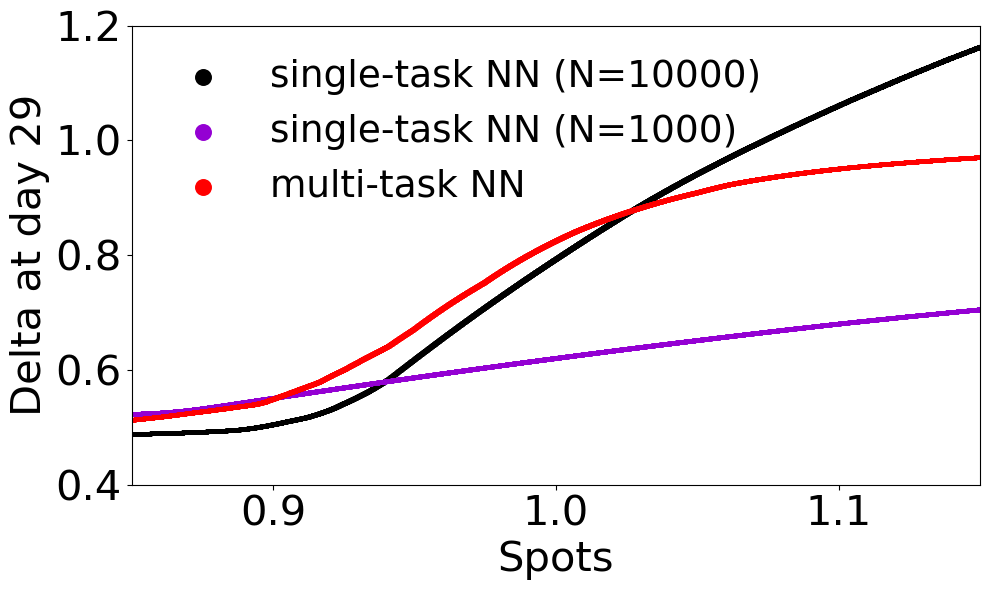

In [109]:
t = 28
plt.figure(figsize=[10,6])
plt.scatter(x = paths_list_single[0][key_list_ST[-6]]['ADS'][t,:], y =delta_list_single[0][key_list_ST[-6]], s = 5,label='single-task NN (N=10000)', alpha=1.,color='black')
plt.scatter(x = paths_list_single_1000[0][key_list_ST[-2]]['ADS'][t,:], y =delta_list_single_1000[0][key_list_ST[-2]], s = 5,label='single-task NN (N=1000)', alpha=1.,color='darkviolet')
for index in loss_retrain.keys():
    if 'emb5seed0n1000' == index:
        plt.scatter(x = paths_test['ADS'][t,:], y =delta_retrain[index], s = 5,label='multi-task NN', alpha=1.,color='red')
plt.xlim([0.85,1.15])
plt.ylim([0.4,1.2])
legend = plt.legend(markerscale=5,fontsize=27,loc='upper left')
legend.get_frame().set_alpha(0.)
plt.xlabel('Spots',size=30)
plt.ylabel('Delta at day 29',size=30)
plt.xticks([0.9,1.,1.1],fontsize = 30)
plt.yticks([0.4,0.6,0.8,1.0,1.2],fontsize = 30)
#plt.title('# train paths = 1000',size=30)
plt.tight_layout()

# Four models

In [332]:
repo = analysis.Repo('./multitask_4models_vanillacalloption/')
key_list = list(repo.results.keys())

In [333]:
experiments = {}
key_list = []
for k,v in repo.results.items():  
        key_list.append(k)

In [334]:
index = 15

In [335]:
import ast  
with open('model_params_dict.txt') as f: 
    data = f.read() 
model_params = ast.literal_eval(data) 

In [336]:
tmp={
        'ref_keys':key_list[index],#key_list[0]
        'labels':{ key_list[index]: 'models'                
        }
}
experiments['models'] = tmp

experiment = 'models'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']

In [337]:
tmp={
        'ref_keys':key_list[index],#key_list[0]
        'labels':{ key_list[index]: 'models'                
        }
}
experiments['models'] = tmp

experiment = 'models'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
#labels_T = {k:v for v,k in labels.items()}
loop = 32#len(vol_list)
model_list = []
for i in range(loop):
    #model.append(GBM(0.,vol_list[i]))
    model_list.append(GBM(drift=model_params['GBM']['drift'][i],volatility=model_params['GBM']['vol'][i]))
    model_list.append(HestonForDeepHedging(rate_of_mean_reversion = model_params['Heston']['rate_of_mean_reversion'][i],
                                      long_run_average = model_params['Heston']['long_run_average'][i],
                                      vol_of_vol = model_params['Heston']['vol_of_vol'][i], 
                                      correlation_rho = model_params['Heston']['correlation_rho'][i],
                                      v0 = model_params['Heston']['v0'][i]))
    model_list.append(HestonWithJumps(rate_of_mean_reversion = model_params['Heston with Jumps']['rate_of_mean_reversion'][i],
                                 long_run_average = model_params['Heston with Jumps']['long_run_average'][i],
                                 vol_of_vol = model_params['Heston with Jumps']['vol_of_vol'][i], 
                                 correlation_rho = model_params['Heston with Jumps']['correlation_rho'][i],
                                 muj = 0.1791,sigmaj = 0.1346, 
                                 lmbda = model_params['Heston with Jumps']['lmbda'][i],
                                 v0 = model_params['Heston with Jumps']['v0'][i]))
    model_list.append(BNS(rho =model_params['BNS']['rho'][i],
                     lmbda=model_params['BNS']['lmbda'][i],
                     b=model_params['BNS']['b'][i],
                     a=model_params['BNS']['a'][i],
                     v0 = model_params['BNS']['v0'][i]))
sim_results_list = []
paths_list = []
pnl_list = []
delta_list = []
hedge_model_list = []
price_list = []


count = 0
n_sims = 16000
t = 28
print('get hedge model and embedding')
hedge_model, embedding = get_hedge_model_and_embedding(ref_keys)
print('get specs')
specs = get_specs(ref_keys)
print('get sim_results, paths, pnl and delta for model:')
for i in model_list:
    print(count,i)
    hedge_model_list.append(hedge_model)
    sim_results, paths = get_sim_results_and_paths(ref_keys,i,count,n_sims)
    sim_results_list.append(sim_results)
#    paths_list.append(paths)
#    pnl = get_pnl(hedge_model, specs, paths_list[count], n_sims)
#    delta = get_delta(hedge_model_list[count], t, paths_list[count],count)
#    pnl_list.append(pnl)
#    delta_list.append(delta)
    price = get_price(ref_keys,i,n_sims,sim_results=sim_results)
    price_list.append(price)
    count = count + 1


get hedge model and embedding
get specs
get sim_results, paths, pnl and delta for model:
0 <rivapy.models.gbm.GBM object at 0x000001CABB0725D0>
1 <rivapy.models.heston_for_DH.HestonForDeepHedging object at 0x000001CAB4287C10>
2 <rivapy.models.heston_with_jumps.HestonWithJumps object at 0x000001CAB4287390>
3 <rivapy.models.barndorff_nielsen_shephard.BNS object at 0x000001CAB42DB850>
4 <rivapy.models.gbm.GBM object at 0x000001CAB4294090>
5 <rivapy.models.heston_for_DH.HestonForDeepHedging object at 0x000001CACB560210>
6 <rivapy.models.heston_with_jumps.HestonWithJumps object at 0x000001CAC8C14D50>
7 <rivapy.models.barndorff_nielsen_shephard.BNS object at 0x000001CABE8160D0>
8 <rivapy.models.gbm.GBM object at 0x000001CABE817090>
9 <rivapy.models.heston_for_DH.HestonForDeepHedging object at 0x000001CAC288BED0>
10 <rivapy.models.heston_with_jumps.HestonWithJumps object at 0x000001CAC39FBE10>
11 <rivapy.models.barndorff_nielsen_shephard.BNS object at 0x000001CAC39FA8D0>
12 <rivapy.models.gbm

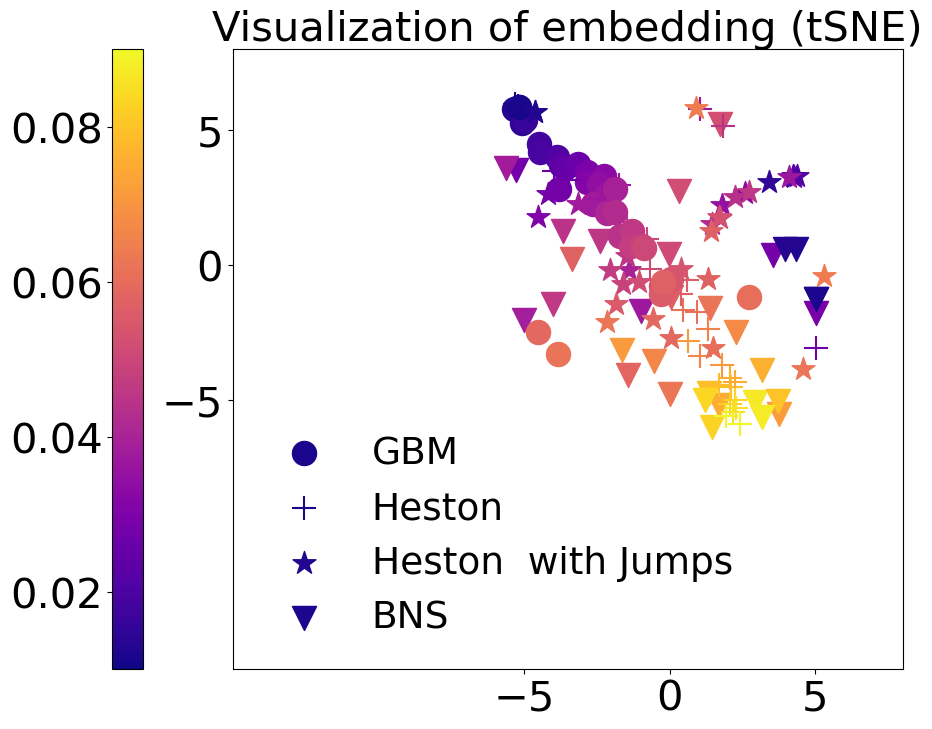

In [340]:
(w,) = embedding[key_list[index]]

#y_subset = list(range(1, len(model_list)))

#import umap  
#manifold = umap.UMAP(n_components=2,random_state=42,n_neighbors=15, min_dist=0.99,metric='euclidean')#.fit(w[:-1])
#X_umap = manifold.fit_transform(w,y_subset)

y_subset = [1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,
            1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,
            1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,
            1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,
            1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,
            1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,
            1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,
            1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,
            1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,
            1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,
            1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,
            1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,
            1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,
            1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,
            1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,
            1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,
            ]

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,random_state=1, n_iter=15000, metric="cosine")
X_umap = tsne.fit_transform(w,y_subset)

modelname = ['GBM','Heston', 'Heston with Jumps', 'BNS']
sign = ['o','+','*','v']
plt.figure(figsize=[10,8])
for i in range(len(model_list)):
    n = y_subset[i]
    sc = plt.scatter(X_umap[i, 0], X_umap[i, 1],c =price_list[i],vmin=0.01, vmax=0.09,cmap='plasma',s=300,marker = sign[n-1]) 
i = 0
plt.scatter(X_umap[i, 0], X_umap[i, 1],c =price_list[i],vmin=0.01, vmax=0.09,cmap='plasma',s=300,label='GBM',marker = sign[i])
i = 1
plt.scatter(X_umap[i, 0], X_umap[i, 1],c =price_list[i],vmin=0.01, vmax=0.09,cmap='plasma',s=300,label='Heston',marker = sign[i]) 
i = 2
plt.scatter(X_umap[i, 0], X_umap[i, 1],c =price_list[i],vmin=0.01, vmax=0.09,cmap='plasma',s=300,label='Heston  with Jumps',marker = sign[i])
i = 3
plt.scatter(X_umap[i, 0], X_umap[i, 1],c =price_list[i],vmin=0.01, vmax=0.09,cmap='plasma',s=300,label='BNS',marker = sign[i])  
cb = plt.colorbar(sc,location='left')#.set_ticks([])
plt.title('Visualization of embedding (tSNE)',size=30)
plt.xticks([-5,0,5],fontsize = 30)
plt.yticks([-5,0,5],fontsize = 30)
plt.xlim([-15,8])
plt.ylim([-15,8])
legend=plt.legend(fontsize=27,loc='lower left')
legend.get_frame().set_alpha(0.)
plt.rc('font', **{'size':'30'})
plt.tight_layout()
plt.show()





In [120]:
def compute_payoff(n_sims, strike, paths):
    payoff = np.zeros((n_sims,))
    #for k in paths.keys():
    v = paths['ADS']
    payoff -= np.maximum(v[-1,:] - strike,0)
    return payoff

In [126]:

sim_results, emb_vec = repo.simulate_model('ADS', n_sims=10000, days = 30, freq='D',model= GBM(drift=0.0, volatility=0.25),emb=128)
hedge_ins = {}
hedge_ins['ADS'] = sim_results

additional_states_ = {}
additional_states_["emb_key"] = emb_vec

paths = {}
paths.update(hedge_ins)
paths.update(additional_states_) 
payoff = compute_payoff(10000,1.,paths)

                    

In [122]:
sim_results, emb_vec = repo.simulate_model('ADS', n_sims=64000, days = 30, freq='D',model= GBM(drift=0.0, volatility=0.25),emb=128)
hedge_ins = {}
hedge_ins['ADS'] = sim_results

additional_states_ = {}
additional_states_["emb_key"] = emb_vec

paths_test = {}
paths_test.update(hedge_ins)
paths_test.update(additional_states_) 
payoff_test = compute_payoff(64000,1.,paths_test)

In [127]:
model_1000, embedding = get_hedge_model_and_embedding(ref_keys)
emb_layer = model_1000[key_list[index]].model.get_layer('Embedding')
print(emb_layer.get_weights())
pnl_pred, pnl_test,delta_test, loss_test = model_1000[key_list[index]].train_task(model=model_1000[key_list[index]],paths=paths, payoff=payoff,paths_test=paths_test, payoff_test=payoff_test)

[array([[-6.7961372e-02, -2.8254083e-01,  1.7618766e-02, ...,
        -1.2553687e-01, -3.5395667e-02,  9.8577119e-02],
       [-6.9720797e-02, -2.3666087e-01, -9.6690729e-03, ...,
        -1.1904842e-01,  5.1721308e-02,  1.2900766e-02],
       [-1.2307142e-01,  8.9528471e-02,  7.0311449e-02, ...,
        -1.1726343e-01,  2.3523191e-02, -1.0388016e-02],
       ...,
       [-2.7134681e-02, -1.6784381e-02, -2.7806962e-02, ...,
         1.2142062e-03,  6.3777789e-03,  2.4009496e-05],
       [-2.5515174e-02,  6.7459121e-03,  1.5952364e-03, ...,
        -4.8662461e-02,  3.8186122e-02,  2.8158192e-02],
       [ 6.4432845e-03,  4.5650195e-02,  4.3541636e-02, ...,
         4.7380064e-02,  2.2907566e-02,  3.4520064e-02]], dtype=float32)]
<keras.engine.input_layer.InputLayer object at 0x000001CA83A0B390> input_16 False
<keras.engine.input_layer.InputLayer object at 0x000001CA81B7CFD0> ADS False
<keras.engine.input_layer.InputLayer object at 0x000001CA86043E10> ttm False
<keras.layers.core.embeddi

In [128]:
delta_new = delta_test.reshape((-1,))

In [102]:
timegrid = VanillaOptionDeepHedgingPricer._compute_timegrid(days=30,freq='D')
model_025 = GBM(drift=0.0, volatility=0.25)
delta_BS_025 = model_025.compute_BS_delta(paths_test['ADS'][t,:],timegrid)


In [230]:
repo = analysis.Repo('./singletask_GBM_vanillacalloption/')
key_list_ST = list(repo.results.keys())

In [289]:
experiments = {}
key_list_ST = []
for k,v in repo.results.items():  
        key_list_ST.append(k)

In [233]:
key_list_ST[-1]

'a676b907f5f7f78bb73106b182c75438722e12d8'

In [239]:
for i in range(len(key_list_ST)):
    print(i,repo.results[key_list_ST[i]]['pricing_param'])

0 {'depth': 3, 'nb_neurons': 64, 'n_sims': 2, 'regularization': 0.0, 'epochs': 1000, 'verbose': 1, 'tensorboard_logdir': 'logs/20240626T143528', 'initial_lr': 0.005, 'decay_steps': 16000, 'batch_size': 256, 'decay_rate': 0.95, 'seed': 0, 'days': 30, 'embedding_size': 1}
1 {'depth': 3, 'nb_neurons': 64, 'n_sims': 2, 'regularization': 0.0, 'epochs': 1000, 'verbose': 1, 'tensorboard_logdir': 'logs/20240626T143558', 'initial_lr': 0.005, 'decay_steps': 16000, 'batch_size': 256, 'decay_rate': 0.95, 'seed': 42, 'days': 30, 'embedding_size': 1}
2 {'depth': 3, 'nb_neurons': 64, 'n_sims': 2, 'regularization': 0.0, 'epochs': 1000, 'verbose': 1, 'tensorboard_logdir': 'logs/20240626T143620', 'initial_lr': 0.005, 'decay_steps': 16000, 'batch_size': 256, 'decay_rate': 0.95, 'seed': 123, 'days': 30, 'embedding_size': 1}
3 {'depth': 3, 'nb_neurons': 64, 'n_sims': 2, 'regularization': 0.0, 'epochs': 1000, 'verbose': 1, 'tensorboard_logdir': 'logs/20240626T143640', 'initial_lr': 0.005, 'decay_steps': 160

In [298]:
index = 40

In [299]:
tmp={
        'ref_keys':key_list_ST[index],#key_list[0]
        'labels':{ key_list_ST[index]: 'GBMonly'                
        }
}
experiments['GBMonly'] = tmp

experiment_ST = 'GBMonly'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
ref_keys
#labels_T = {k:v for v,k in labels.items()}
#loop = 4
#model_list = []
#for i in range(loop):
#    model_list.append(HestonForDeepHedging(rate_of_mean_reversion = model_params['Heston']['rate_of_mean_reversion'][i],
#                                      long_run_average = model_params['Heston']['long_run_average'][i],
#                                      vol_of_vol = model_params['Heston']['vol_of_vol'][i], 
#                                      correlation_rho = model_params['Heston']['correlation_rho'][i],
#                                      v0 = model_params['Heston']['v0'][i]))
model_list_single = [GBM(drift=0.0, volatility=0.25)]
sim_results_list_single = []
paths_list_single = []
pnl_list_single = []
delta_list_single = []
hedge_model_list_single = []


count = 0
n_sims = 64000
t = 28
print('get hedge model and embedding')
hedge_model, embedding = get_hedge_model_and_embedding(ref_keys)
embedding
print('get specs')
specs = get_specs(ref_keys)
print('get sim_results, paths, pnl and delta for model:')
for i in model_list_single:
    hedge_model_list_single.append(hedge_model)
    sim_results, paths = get_sim_results_and_paths(ref_keys,i,count,n_sims)
    sim_results_list_single.append(sim_results)
    paths_list_single.append(paths)
    pnl = get_pnl(hedge_model, specs, paths_list_single[count], n_sims)
    delta = get_delta(hedge_model_list_single[count], t, paths_list_single[count],count)
    pnl_list_single.append(pnl)
    delta_list_single.append(delta)
    count = count + 1


get hedge model and embedding
get specs
get sim_results, paths, pnl and delta for model:
2000/2000 [==============================] - 2s 1ms/step


In [300]:
print(pnl[ref_keys].mean(), pnl[ref_keys].var(),skew(pnl[ref_keys]))

-0.029093720781162395 4.0042507726812105e-05 -0.7937412879260362


In [257]:
repo = analysis.Repo('./multitask_4models_vanillacalloption/')
key_list = list(repo.results.keys())

In [258]:
experiments = {}
key_list = []
for k,v in repo.results.items():  
        key_list.append(k)

In [261]:
index_list = []
for i in range(len(key_list)):
    #tc = repo.results[key_list[i]]['pricing_param']['transaction_cost']['ADS'][0]
    seed = repo.results[key_list[i]]['pricing_param']['seed']
    emb = repo.results[key_list[i]]['pricing_param']['embedding_size']
    if seed == 0 and (emb == 4,emb == 16,emb == 64):
        index_list.append(i)


In [262]:
for index in index_list:
    name = 'emb'+str(repo.results[key_list[index]]['pricing_param']['embedding_size'])+'seed'+str(repo.results[key_list[index]]['pricing_param']['seed'])               
    tmp={
        'ref_keys':key_list[index],
        'labels':{ key_list[index]: name
        }
    }
    experiments[name] = tmp

In [263]:
experiments.keys()

dict_keys(['emb64seed0', 'emb4seed0', 'emb8seed0', 'emb16seed0', 'emb32seed0'])

In [264]:
def compute_payoff(n_sims, strike, paths):
    payoff = np.zeros((n_sims,))
    #for k in paths.keys():
    v = paths['ADS']
    payoff -= np.maximum(v[-1,:] - strike,0)
    return payoff

In [265]:
sim_results, emb_vec = repo.simulate_model('ADS', n_sims=64000, days = 30, freq='D',model= GBM(drift=0.0, volatility=0.25),emb=128)
hedge_ins = {}
hedge_ins['ADS'] = sim_results

additional_states_ = {}
additional_states_["emb_key"] = emb_vec

paths_test = {}
paths_test.update(hedge_ins)
paths_test.update(additional_states_) 
payoff_test = compute_payoff(64000,1.,paths_test)

In [267]:
pnl_retrain = {}
delta_retrain = {}
loss_retrain = {}
for index in experiments.keys():
    ref_keys = experiments[index]['ref_keys']
    for n_sims in [10,100,1000,10000]:
        sim_results, emb_vec = repo.simulate_model('ADS', n_sims=n_sims, days = 30, freq='D',model= GBM(drift=0.0, volatility=0.25),emb=128)
        hedge_ins = {}
        hedge_ins['ADS'] = sim_results

        additional_states_ = {}
        additional_states_["emb_key"] = emb_vec

        paths = {}
        paths.update(hedge_ins)
        paths.update(additional_states_) 
        payoff = compute_payoff(n_sims,1.,paths)

        model_retrain, embedding = get_hedge_model_and_embedding(ref_keys)
        pnl_pred, pnl_test,delta_test, loss_train = model_retrain[ref_keys].train_task(model=model_retrain[ref_keys],paths=paths, payoff=payoff,paths_test=paths_test, payoff_test=payoff_test)
        pnl_retrain[str(index)+'n'+str(n_sims)] = pnl_test
        delta_retrain[str(index)+'n'+str(n_sims)] = delta_test
        loss_retrain[str(index)+'n'+str(n_sims)] = loss_train

<keras.engine.input_layer.InputLayer object at 0x000001CAB4E316D0> input_21 False
<keras.engine.input_layer.InputLayer object at 0x000001CABCB35C50> ADS False
<keras.engine.input_layer.InputLayer object at 0x000001CB47B62D10> ttm False
<keras.layers.core.embedding.Embedding object at 0x000001CB4E285350> Embedding True
<keras.layers.merging.concatenate.Concatenate object at 0x000001CB4E284290> concatenate_40 False
<keras.layers.reshaping.flatten.Flatten object at 0x000001CB42A68510> flatten_20 False
<keras.layers.merging.concatenate.Concatenate object at 0x000001CB42A686D0> concatenate_41 False
<keras.layers.core.dense.Dense object at 0x000001CB4E294250> dense_100 False
<keras.layers.core.dense.Dense object at 0x000001CB469F8A50> dense_101 False
<keras.layers.core.dense.Dense object at 0x000001CB469F9550> dense_102 False
<keras.layers.core.dense.Dense object at 0x000001CB42A63D90> dense_103 False
<keras.layers.core.dense.Dense object at 0x000001CB4E2EBE10> dense_104 False
Epoch 1/10
1/1

In [269]:
np.random.seed(123)
n = 30
T = n/365
ttm = T
S0 = 1.#24.6144
K = S0

model_GBM = GBM(0,0.25)
price = model_GBM.compute_call_price(S0=S0,v0=0,K=K,ttm=ttm)
print(price)

0.028587180295691406


In [270]:
from scipy.stats import skew 
for index in loss_retrain.keys():
    print(index, pnl_retrain[index].mean()+price, pnl_retrain[index].var(),skew(pnl_retrain[index]))

emb64seed0n10 -0.0004901541446039603 8.691175913787395e-05 -0.07485713126253696
emb64seed0n100 -0.0004982033025177357 6.76717143395303e-05 0.19170604951430165
emb64seed0n1000 -0.000508156070968338 3.907001564635985e-05 0.042340102097966695
emb64seed0n10000 -0.000503777343767664 3.153183405138336e-05 -0.40144863687674487
emb4seed0n10 -0.00047931208792093005 9.058381753774832e-05 -0.3832064396134649
emb4seed0n100 -0.000494557358778052 6.405510387541552e-05 0.16015474710908548
emb4seed0n1000 -0.000505500417161471 4.3072172720625796e-05 0.22034756213983658
emb4seed0n10000 -0.0005074722057785523 3.2839644652295136e-05 -0.13865936714085836
emb8seed0n10 -0.00048165596097774627 9.484541058133959e-05 -0.3326399872376674
emb8seed0n100 -0.0004933871728887013 7.123767425718974e-05 0.02955789474857783
emb8seed0n1000 -0.0005063506169123259 4.2002075433770845e-05 0.09444071882184044
emb8seed0n10000 -0.0005098446352518778 3.18982894968373e-05 -0.3194139300558996
emb16seed0n10 -0.00048179934297755064 9

{'val_date': '2023-01-01T00:00:00', 'spec': [{'id': 'Test_Call1', 'issuer': 'DBK', 'sec_lvl': 'COLLATERALIZED', 'curr': 'EUR', 'udl_id': 'ADS', 'type': 'CALL', 'expiry': '2023-01-31T00:00:00', 'strike': 1.0, 'share_ratio': 1, 'long_short_flag': 'long', 'cls': 'EuropeanVanillaSpecification'}], 'model': [{'drift': 0.0, 'volatility': 0.25, 'cls': 'GBM'}], 'pricing_param': {'depth': 3, 'nb_neurons': 64, 'n_sims': 10000, 'regularization': 0.0, 'epochs': 1000, 'verbose': 1, 'tensorboard_logdir': 'logs/20240626T172127', 'initial_lr': 0.005, 'decay_steps': 16000, 'batch_size': 256, 'decay_rate': 0.95, 'seed': 0, 'days': 30, 'embedding_size': 1}, 'spec_hash': {'Test_Call1': 'c256412e687a022f6453d9a3f2095801befda8f4'}, 'model_hash': {'GBM': 'd9b7606c19e32707ca553822bcbb7ea3a6ba1ee5'}, 'pricing_params_hash': '4a1ffe7272e25cff3e17b2c5658a556aeef0d7eb', 'pnl_result': {'mean': -0.028446848574389713, 'var': 3.33102005301309e-05, 'loss': 3.219519567210227e-05, '1%': -0.04323396272957325, '99%': -0.015

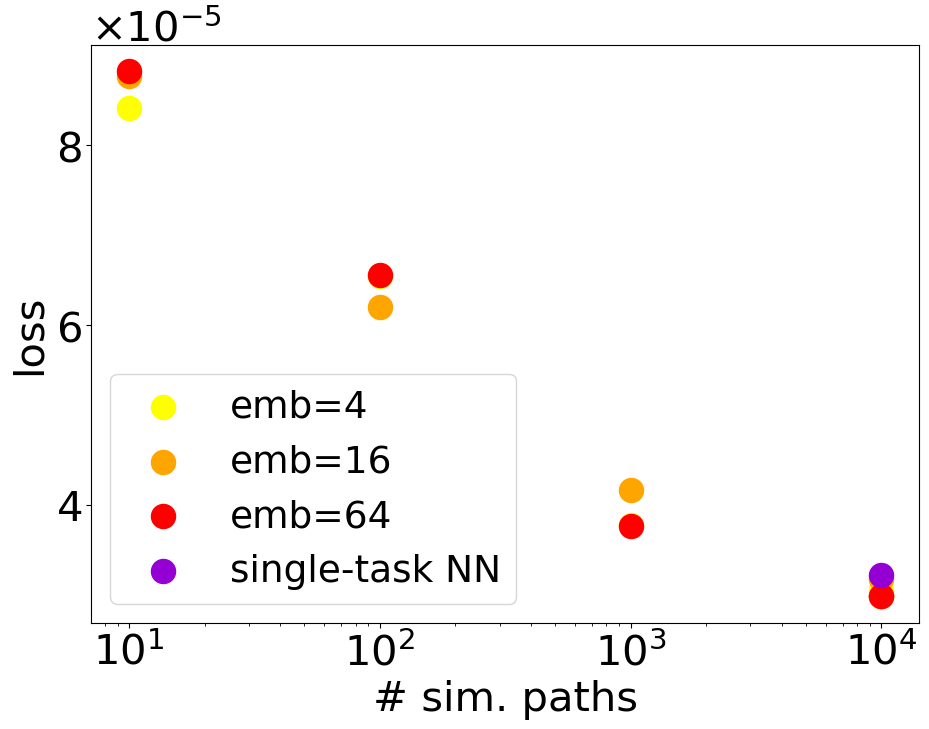

In [301]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

n_sims_list = [10,100,1000,10000,10,100,1000,10000,10,100,1000,10000]
colors = ['yellow','yellow','yellow','yellow','orange','orange','orange','orange','red','red','red','red']
emb = [4,4,4,4,16,16,16,16,64,64,64,64]
count = 0
plt.figure(figsize=[10,8])
for index in loss_retrain.keys():
    if ('emb64' in index or 'emb16' in index or 'emb4' in index):
        plt.scatter(n_sims_list[count],loss_retrain[index],color=colors[count],s=300.)
        count = count + 1
count = 3
plt.scatter(n_sims_list[count],loss_retrain['emb16seed0n10000'],color=colors[count],s=300.,label='emb='+str(emb[count]))
count = 7
plt.scatter(n_sims_list[count],loss_retrain['emb16seed0n10000'],color=colors[count],s=300.,label='emb='+str(emb[count]))
count = 11
plt.scatter(n_sims_list[count],loss_retrain['emb16seed0n10000'],color=colors[count],s=300.,label='emb='+str(emb[count]))
for ii in [40]:
    repo = analysis.Repo('./singletask_GBM_vanillacalloption/')
    key_list_ST = []
    for k,v in repo.results.items():  
        key_list_ST.append(k)       
    N = repo.results[key_list_ST[ii]]['pricing_param']['n_sims']
    L = repo.results[key_list_ST[ii]]['pnl_result']['loss']
    print(repo.results[key_list_ST[40]])
    plt.scatter(N,L,s=300.,color='darkviolet',label='single-task NN')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('# sim. paths',size=30)
plt.ylabel('loss',size=30)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(fontsize=27,loc='lower left')
plt.rc('font', **{'size':'30'})
plt.ticklabel_format(axis='y', style='sci',useMathText=True,)
plt.tight_layout()

In [281]:
paths_test

{'ADS': array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        [1.00654367, 0.99193583, 0.99355482, ..., 0.99734393, 1.00566319,
         1.01478317],
        [1.00460415, 1.01660342, 0.99101501, ..., 1.01566598, 1.00896916,
         1.0123394 ],
        ...,
        [0.93638674, 0.93402669, 1.00288837, ..., 0.93376406, 1.1658413 ,
         0.93824249],
        [0.92884876, 0.93807071, 0.99575394, ..., 0.90872761, 1.16397671,
         0.95106054],
        [0.92516779, 0.95024571, 1.00249065, ..., 0.89855976, 1.19100398,
         0.96780319]]),
 'emb_key': array([128., 128., 128., ..., 128., 128., 128.])}

In [288]:
repo = analysis.Repo('./singletask_GBM_vanillacalloption/')
key_list_ST = list(repo.results.keys())

for i in range(len(key_list)):
    print(i,repo.results[key_list[i]])

KeyError: '7248a96634fbe9aa19a507d6993b4e8df3ed2a85'

In [319]:
t = 28
repo = analysis.Repo('./singletask_GBM_vanillacalloption/')
key_list_ST = []
for k,v in repo.results.items():  
    key_list_ST.append(k)   
index = 30
tmp={
        'ref_keys':key_list_ST[index],#key_list[0]
        'labels':{ key_list_ST[index]: 'GBMonly'                
        }
}
experiments['GBMonly'] = tmp

experiment_ST = 'GBMonly'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
ref_keys
#labels_T = {k:v for v,k in labels.items()}
#loop = 4
#model_list = []
#for i in range(loop):
#    model_list.append(HestonForDeepHedging(rate_of_mean_reversion = model_params['Heston']['rate_of_mean_reversion'][i],
#                                      long_run_average = model_params['Heston']['long_run_average'][i],
#                                      vol_of_vol = model_params['Heston']['vol_of_vol'][i], 
#                                      correlation_rho = model_params['Heston']['correlation_rho'][i],
#                                      v0 = model_params['Heston']['v0'][i]))
model_list_single = [GBM(drift=0.0, volatility=0.25)]
sim_results_list_single = []
paths_list_single = []
pnl_list_single = []
delta_list_single = []
hedge_model_list_single = []


count = 0
n_sims = 64000
t = 28
print('get hedge model and embedding')
hedge_model, embedding = get_hedge_model_and_embedding(ref_keys)
embedding
print('get specs')
specs = get_specs(ref_keys)
print('get sim_results, paths, pnl and delta for model:')
for i in model_list_single:
    hedge_model_list_single.append(hedge_model)
    sim_results, paths = get_sim_results_and_paths(ref_keys,i,count,n_sims)
    sim_results_list_single.append(sim_results)
    paths_list_single.append(paths)
    pnl = get_pnl(hedge_model, specs, paths_list_single[count], n_sims)
    delta = get_delta(hedge_model_list_single[count], t, paths_list_single[count],count)
    pnl_list_single.append(pnl)
    delta_list_single.append(delta)
    count = count + 1
 

get hedge model and embedding
get specs
get sim_results, paths, pnl and delta for model:
2000/2000 [==============================] - 2s 1ms/step


In [320]:
t = 28
repo = analysis.Repo('./singletask_GBM_vanillacalloption/')
key_list_ST = []
for k,v in repo.results.items():  
    key_list_ST.append(k)   
index = 35
tmp={
        'ref_keys':key_list_ST[index],#key_list[0]
        'labels':{ key_list_ST[index]: 'GBMonly'                
        }
}
experiments['GBMonly'] = tmp

experiment_ST = 'GBMonly'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
ref_keys
#labels_T = {k:v for v,k in labels.items()}
#loop = 4
#model_list = []
#for i in range(loop):
#    model_list.append(HestonForDeepHedging(rate_of_mean_reversion = model_params['Heston']['rate_of_mean_reversion'][i],
#                                      long_run_average = model_params['Heston']['long_run_average'][i],
#                                      vol_of_vol = model_params['Heston']['vol_of_vol'][i], 
#                                      correlation_rho = model_params['Heston']['correlation_rho'][i],
#                                      v0 = model_params['Heston']['v0'][i]))
model_list_single2 = [GBM(drift=0.0, volatility=0.25)]
sim_results_list_single2 = []
paths_list_single2 = []
pnl_list_single2 = []
delta_list_single2 = []
hedge_model_list_single2 = []


count = 0
n_sims = 64000
t = 28
print('get hedge model and embedding')
hedge_model, embedding = get_hedge_model_and_embedding(ref_keys)
embedding
print('get specs')
specs = get_specs(ref_keys)
print('get sim_results, paths, pnl and delta for model:')
for i in model_list_single:
    hedge_model_list_single2.append(hedge_model)
    sim_results, paths = get_sim_results_and_paths(ref_keys,i,count,n_sims)
    sim_results_list_single2.append(sim_results)
    paths_list_single2.append(paths)
    pnl = get_pnl(hedge_model, specs, paths_list_single2[count], n_sims)
    delta = get_delta(hedge_model_list_single2[count], t, paths_list_single2[count],count)
    pnl_list_single2.append(pnl)
    delta_list_single2.append(delta)
    count = count + 1
 

get hedge model and embedding
get specs
get sim_results, paths, pnl and delta for model:
2000/2000 [==============================] - 4s 2ms/step


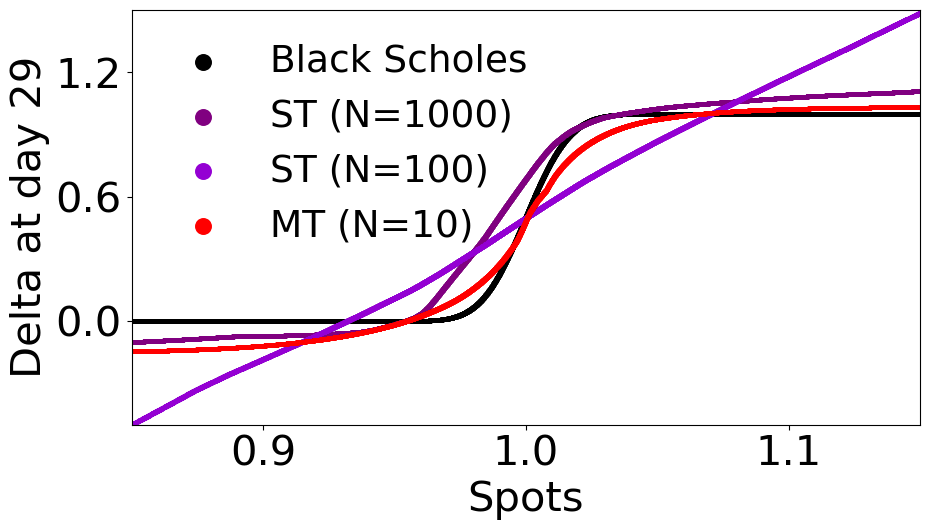

In [330]:

plt.figure(figsize=[10,6])
plt.scatter(x = paths_test['ADS'][t,:], y = delta_BS_025, label ='Black Scholes', color = 'black',s = 5)
index = 35
plt.scatter(x = paths_list_single2[0][key_list_ST[index]]['ADS'][t,:], y =delta_list_single2[0][key_list_ST[index]], s = 5,label='ST (N=1000)', alpha=1.,color='purple')
index = 30
plt.scatter(x = paths_list_single[0][key_list_ST[index]]['ADS'][t,:], y =delta_list_single[0][key_list_ST[index]], s = 5,label='ST (N=100)', alpha=1.,color='darkviolet')
for index in loss_retrain.keys():
    if 'emb64seed0n10' == index:
        plt.scatter(x = paths_test['ADS'][t,:], y =delta_retrain[index], s = 5,label='MT (N=10)', alpha=1.,color='red')
plt.xlim([0.85,1.15])
plt.ylim([-0.5,1.5])
legend = plt.legend(markerscale=5,fontsize=27,loc='upper left')
legend.get_frame().set_alpha(0.)
plt.xlabel('Spots',size=30)
plt.ylabel('Delta at day 29',size=30)
plt.xticks([0.9,1.,1.1],fontsize = 30)
plt.yticks([0.,0.6,1.2],fontsize = 30)
#plt.title('# train paths = 1000',size=30)
plt.tight_layout()

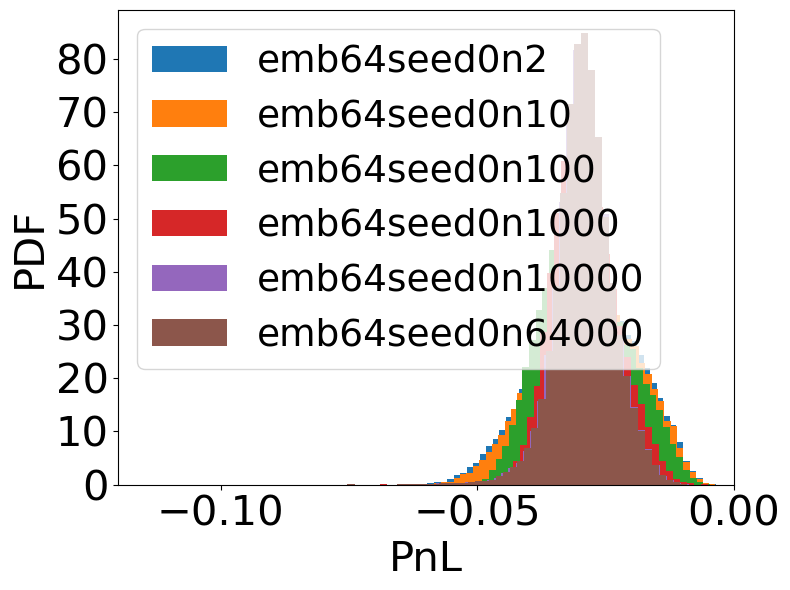

In [205]:
vol = [0.1,0.2,0.3,0.4,0.25]
colors =  ['aquamarine','turquoise','lightseagreen','mediumturquoise','red']
pnl_statistics = {}
plt.figure(figsize=[8,6])
for index in loss_retrain.keys():
    plt.hist(pnl_retrain[index], bins=50, alpha=1.,density = True,label=index)
#plt.hist(pnl_list_single[0][key_list_ST[40]],bins=50, label='single-task NN', alpha=.7,color='darkviolet',density = True)
plt.legend()
plt.xlim([-0.12,0.])
plt.legend(markerscale=5,fontsize=27,loc='upper left')
plt.xlabel('PnL',size=30)
plt.ylabel('PDF',size=30)
plt.xticks([-0.1,-0.05,0.0],fontsize = 30)
plt.yticks(fontsize = 30)
plt.tight_layout()

# Four models (1600)

In [107]:
repo = analysis.Repo('./multitask_4models_vanillacalloption_1600/')
key_list = list(repo.results.keys())

In [108]:
experiments = {}
key_list = []
for k,v in repo.results.items():  
        key_list.append(k)

In [109]:
for i in range(len(key_list)):
    print(i, repo.results[key_list[i]]['pricing_param'])

0 {'depth': 3, 'nb_neurons': 64, 'n_sims': 2048000, 'regularization': 0.0, 'epochs': 50, 'verbose': 1, 'tensorboard_logdir': 'logs/20240703T091933', 'initial_lr': 0.005, 'decay_steps': 16000, 'batch_size': 256, 'decay_rate': 0.95, 'seed': 0, 'days': 30, 'embedding_size': 4}
1 {'depth': 3, 'nb_neurons': 64, 'n_sims': 2048000, 'regularization': 0.0, 'epochs': 50, 'verbose': 1, 'tensorboard_logdir': 'logs/20240703T095622', 'initial_lr': 0.005, 'decay_steps': 16000, 'batch_size': 256, 'decay_rate': 0.95, 'seed': 42, 'days': 30, 'embedding_size': 4}
2 {'depth': 3, 'nb_neurons': 64, 'n_sims': 2048000, 'regularization': 0.0, 'epochs': 50, 'verbose': 1, 'tensorboard_logdir': 'logs/20240703T103300', 'initial_lr': 0.005, 'decay_steps': 16000, 'batch_size': 256, 'decay_rate': 0.95, 'seed': 123, 'days': 30, 'embedding_size': 4}
3 {'depth': 3, 'nb_neurons': 64, 'n_sims': 2048000, 'regularization': 0.0, 'epochs': 50, 'verbose': 1, 'tensorboard_logdir': 'logs/20240703T110844', 'initial_lr': 0.005, 'd

In [110]:
index = 20

In [111]:
import ast  
with open('model_params_dict.txt') as f: 
    data = f.read() 
model_params = ast.literal_eval(data) 

In [112]:
tmp={
        'ref_keys':key_list[index],#key_list[0]
        'labels':{ key_list[index]: 'models'                
        }
}
experiments['models'] = tmp

experiment = 'models'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']

In [113]:
tmp={
        'ref_keys':key_list[index],#key_list[0]
        'labels':{ key_list[index]: 'models'                
        }
}
experiments['models'] = tmp

experiment = 'models'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
#labels_T = {k:v for v,k in labels.items()}
loop = 320#len(vol_list)
model_list = []
for i in range(loop):
    #model.append(GBM(0.,vol_list[i]))
    model_list.append(GBM(drift=model_params['GBM']['drift'][i],volatility=model_params['GBM']['vol'][i]))
    model_list.append(HestonForDeepHedging(rate_of_mean_reversion = model_params['Heston']['rate_of_mean_reversion'][i],
                                      long_run_average = model_params['Heston']['long_run_average'][i],
                                      vol_of_vol = model_params['Heston']['vol_of_vol'][i], 
                                      correlation_rho = model_params['Heston']['correlation_rho'][i],
                                      v0 = model_params['Heston']['v0'][i]))
    model_list.append(HestonWithJumps(rate_of_mean_reversion = model_params['Heston with Jumps']['rate_of_mean_reversion'][i],
                                 long_run_average = model_params['Heston with Jumps']['long_run_average'][i],
                                 vol_of_vol = model_params['Heston with Jumps']['vol_of_vol'][i], 
                                 correlation_rho = model_params['Heston with Jumps']['correlation_rho'][i],
                                 muj = 0.1791,sigmaj = 0.1346, 
                                 lmbda = model_params['Heston with Jumps']['lmbda'][i],
                                 v0 = model_params['Heston with Jumps']['v0'][i]))
    model_list.append(BNS(rho =model_params['BNS']['rho'][i],
                     lmbda=model_params['BNS']['lmbda'][i],
                     b=model_params['BNS']['b'][i],
                     a=model_params['BNS']['a'][i],
                     v0 = model_params['BNS']['v0'][i]))
sim_results_list = []
paths_list = []
pnl_list = []
delta_list = []
hedge_model_list = []
price_list = []


count = 0
n_sims = 1600
t = 28
print('get hedge model and embedding')
hedge_model, embedding = get_hedge_model_and_embedding(ref_keys)
print('get specs')
specs = get_specs(ref_keys)
print('get sim_results, paths, pnl and delta for model:')
for i in model_list:
    print(count,i)
    hedge_model_list.append(hedge_model)
    sim_results, paths = get_sim_results_and_paths(ref_keys,i,count,n_sims)
    sim_results_list.append(sim_results)
#    paths_list.append(paths)
#    pnl = get_pnl(hedge_model, specs, paths_list[count], n_sims)
#    delta = get_delta(hedge_model_list[count], t, paths_list[count],count)
#    pnl_list.append(pnl)
#    delta_list.append(delta)
    price = get_price(ref_keys,i,n_sims,sim_results=sim_results)
    price_list.append(price)
    count = count + 1


get hedge model and embedding
get specs
get sim_results, paths, pnl and delta for model:
0 <rivapy.models.gbm.GBM object at 0x0000016EC8789A90>
1 <rivapy.models.heston_for_DH.HestonForDeepHedging object at 0x0000016EC8577D10>
2 <rivapy.models.heston_with_jumps.HestonWithJumps object at 0x0000016EA332F910>
3 <rivapy.models.barndorff_nielsen_shephard.BNS object at 0x0000016EA332F050>
4 <rivapy.models.gbm.GBM object at 0x0000016ECBC47350>
5 <rivapy.models.heston_for_DH.HestonForDeepHedging object at 0x0000016FFB7AA6D0>
6 <rivapy.models.heston_with_jumps.HestonWithJumps object at 0x0000016EED41AB50>
7 <rivapy.models.barndorff_nielsen_shephard.BNS object at 0x0000016ED986B850>
8 <rivapy.models.gbm.GBM object at 0x0000016ED9869FD0>
9 <rivapy.models.heston_for_DH.HestonForDeepHedging object at 0x0000016ECDE73D90>
10 <rivapy.models.heston_with_jumps.HestonWithJumps object at 0x0000016ED986BF50>
11 <rivapy.models.barndorff_nielsen_shephard.BNS object at 0x0000016ED986AE10>
12 <rivapy.models.gbm

In [114]:
# open file in write mode
with open(r'price_list.txt', 'w') as fp:
    for item in price_list:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


In [102]:
bla = embedding[key_list[index]]
len(bla[0][:,0])

1281

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279


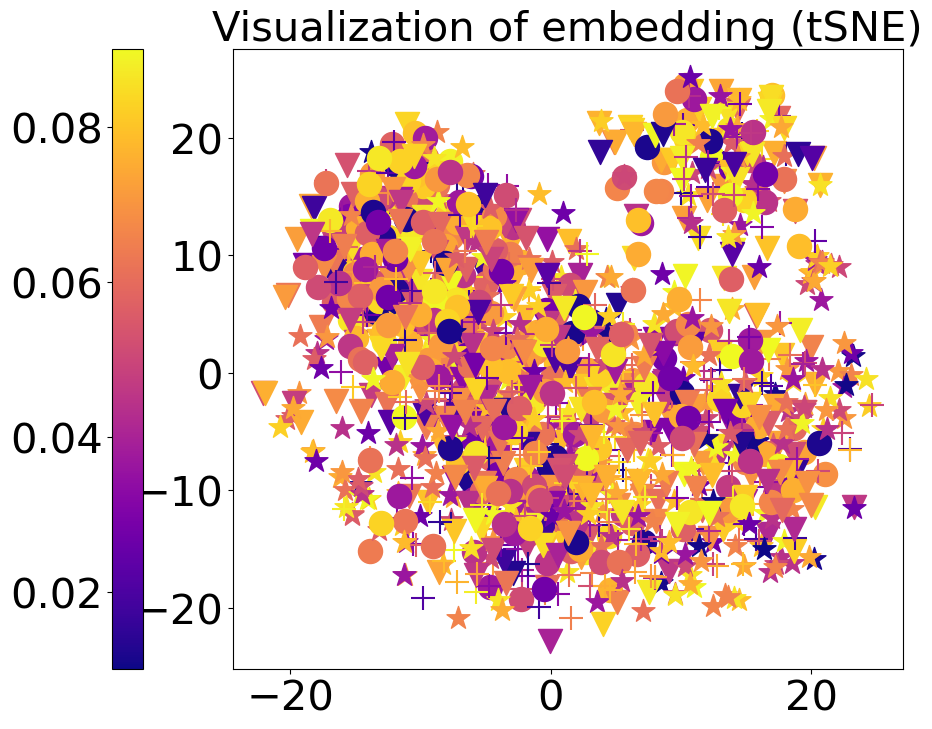

In [115]:
(w,) = embedding[key_list[index]]

#y_subset = list(range(1, len(model_list)))

#import umap  
#manifold = umap.UMAP(n_components=2,random_state=42,n_neighbors=15, min_dist=0.99,metric='euclidean')#.fit(w[:-1])
#X_umap = manifold.fit_transform(w,y_subset)


from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,random_state=1, n_iter=15000, metric="cosine")
X_umap = tsne.fit_transform(w)

modelname = ['GBM','Heston', 'Heston with Jumps', 'BNS']
sign = ['o','+','*','v']
plt.figure(figsize=[10,8])
count = 1
for i in range(len(model_list)):
    print(i)
    n = count#y_subset[i]
    count = count + 1
    if count == 4:
        count = 0
    sc = plt.scatter(X_umap[i, 0], X_umap[i, 1],vmin=0.01, vmax=0.09,cmap='plasma',s=300,marker = sign[n-1],c =price_list[i-1]) 
#i = 0
#plt.scatter(X_umap[i, 0], X_umap[i, 1],c =price_list[i],vmin=0.01, vmax=0.09,cmap='plasma',s=300,label='GBM',marker = sign[i])
#i = 1
#plt.scatter(X_umap[i, 0], X_umap[i, 1],c =price_list[i],vmin=0.01, vmax=0.09,cmap='plasma',s=300,label='Heston',marker = sign[i]) 
#i = 2
#plt.scatter(X_umap[i, 0], X_umap[i, 1],c =price_list[i],vmin=0.01, vmax=0.09,cmap='plasma',s=300,label='Heston  with Jumps',marker = sign[i])
#i = 3
#plt.scatter(X_umap[i, 0], X_umap[i, 1],c =price_list[i],vmin=0.01, vmax=0.09,cmap='plasma',s=300,label='BNS',marker = sign[i])  
cb = plt.colorbar(sc,location='left')#.set_ticks([])
plt.title('Visualization of embedding (tSNE)',size=30)
#plt.xticks([-5,0,5],fontsize = 30)
#plt.yticks([-5,0,5],fontsize = 30)
#plt.xlim([-15,8])
#plt.ylim([-15,8])
legend=plt.legend(fontsize=27,loc='lower left')
legend.get_frame().set_alpha(0.)
plt.rc('font', **{'size':'30'})
plt.tight_layout()
plt.show()





In [116]:
def compute_payoff(n_sims, strike, paths):
    payoff = np.zeros((n_sims,))
    #for k in paths.keys():
    v = paths['ADS']
    payoff -= np.maximum(v[-1,:] - strike,0)
    return payoff

In [117]:
sim_results, emb_vec = repo.simulate_model('ADS', n_sims=10000, days = 30, freq='D',model= GBM(drift=0.0, volatility=0.25),emb=128)
hedge_ins = {}
hedge_ins['ADS'] = sim_results

additional_states_ = {}
additional_states_["emb_key"] = emb_vec

paths = {}
paths.update(hedge_ins)
paths.update(additional_states_) 
payoff = compute_payoff(10000,1.,paths)

In [118]:
sim_results, emb_vec = repo.simulate_model('ADS', n_sims=64000, days = 30, freq='D',model= GBM(drift=0.0, volatility=0.25),emb=128)
hedge_ins = {}
hedge_ins['ADS'] = sim_results

additional_states_ = {}
additional_states_["emb_key"] = emb_vec

paths_test = {}
paths_test.update(hedge_ins)
paths_test.update(additional_states_) 
payoff_test = compute_payoff(64000,1.,paths_test)

In [119]:
model_1000, embedding = get_hedge_model_and_embedding(ref_keys)
emb_layer = model_1000[key_list[index]].model.get_layer('Embedding')
print(emb_layer.get_weights())
pnl_pred, pnl_test,delta_test, loss_test = model_1000[key_list[index]].train_task(model=model_1000[key_list[index]],paths=paths, payoff=payoff,paths_test=paths_test, payoff_test=payoff_test)

[array([[ 6.7073517e-02,  2.8330892e-02, -2.6562491e-01, ...,
        -1.2916318e-02, -1.3440140e-01, -4.8109803e-02],
       [ 1.3939185e-02, -2.9478088e-01,  1.5253360e-02, ...,
         1.2731449e-01, -2.4775875e-01,  2.8634521e-01],
       [ 1.6232581e-01,  5.6801164e-03,  4.9295402e-01, ...,
        -2.6587656e-01,  4.3010037e-02,  3.5563022e-02],
       ...,
       [-4.2006802e-02,  3.1439912e-02,  3.6255311e-02, ...,
        -1.0034453e-02,  3.7650619e-02, -4.8300792e-02],
       [ 1.1286594e-02, -1.0592863e-04, -3.7866078e-02, ...,
        -4.5336973e-02,  1.9495893e-02, -4.3757726e-02],
       [ 1.9536722e-02,  1.9310538e-02,  2.0900965e-03, ...,
        -4.1432619e-02, -2.3781931e-02,  6.6989884e-03]], dtype=float32)]
<keras.engine.input_layer.InputLayer object at 0x0000016E821476D0> input_21 False
<keras.engine.input_layer.InputLayer object at 0x0000016EC8A40A10> ADS False
<keras.engine.input_layer.InputLayer object at 0x0000016E82146E50> ttm False
<keras.layers.core.embeddi

In [120]:
delta_new = delta_test.reshape((-1,))

In [121]:
timegrid = VanillaOptionDeepHedgingPricer._compute_timegrid(days=30,freq='D')
model_025 = GBM(drift=0.0, volatility=0.25)
delta_BS_025 = model_025.compute_BS_delta(paths_test['ADS'][t,:],timegrid)


In [122]:
delta_new

array([-0.07908696, -0.08218187,  0.28782064, ..., -0.08250982,
        1.0077677 , -0.07645947], dtype=float32)

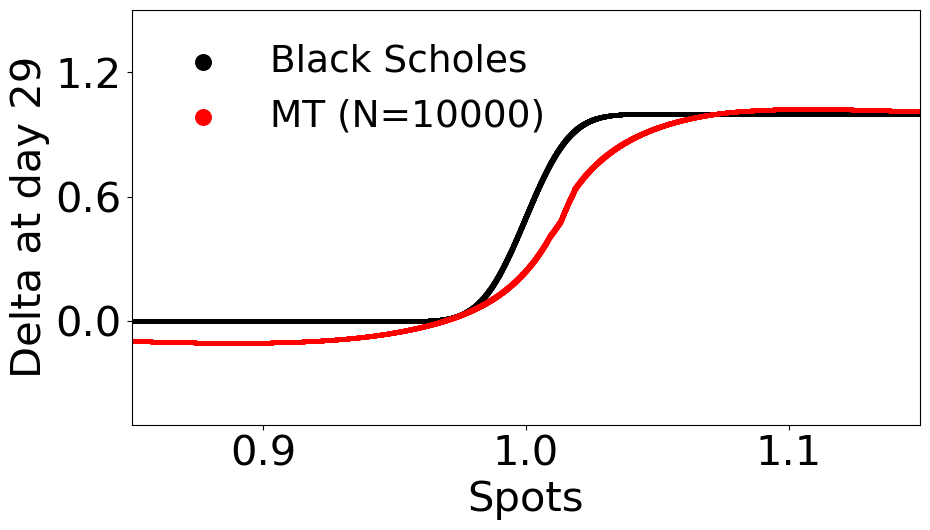

In [124]:

plt.figure(figsize=[10,6])
plt.scatter(x = paths_test['ADS'][t,:], y = delta_BS_025, label ='Black Scholes', color = 'black',s = 5)
plt.scatter(x = paths_test['ADS'][t,:], y =delta_new, s = 5,label='MT (N=10000)', alpha=1.,color='red')
plt.xlim([0.85,1.15])
plt.ylim([-0.5,1.5])
legend = plt.legend(markerscale=5,fontsize=27,loc='upper left')
legend.get_frame().set_alpha(0.)
plt.xlabel('Spots',size=30)
plt.ylabel('Delta at day 29',size=30)
plt.xticks([0.9,1.,1.1],fontsize = 30)
plt.yticks([0.,0.6,1.2],fontsize = 30)
#plt.title('# train paths = 1000',size=30)
plt.tight_layout()